In [6]:
import sys
!{sys.executable} -m pip install openpyxl



Procesando hoja/estación: Campo Marte


C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\3341325829.py:35: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)  # intento día/mes/año


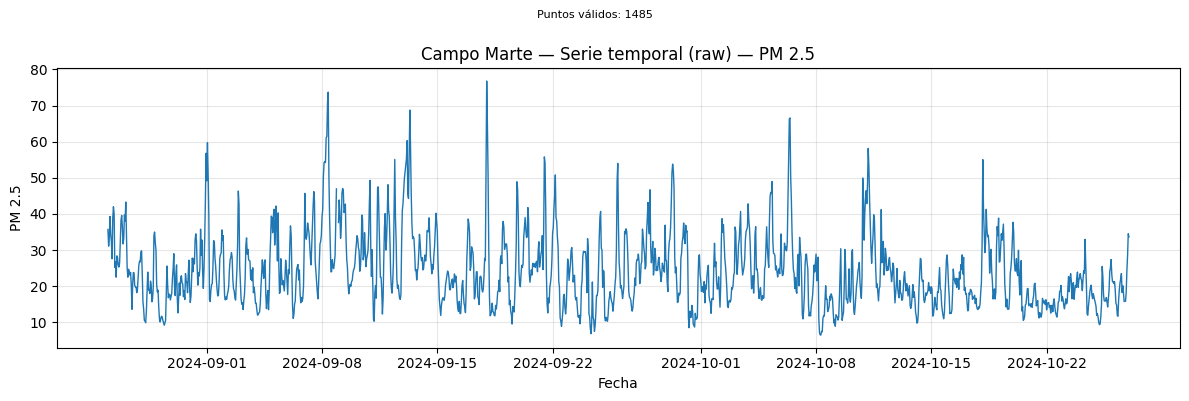

  Guardado plot: plots_raw_one_pollutant\Campo_Marte_PM_2.5_timeseries.png

Procesando hoja/estación: San Borja


C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\3341325829.py:35: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)  # intento día/mes/año


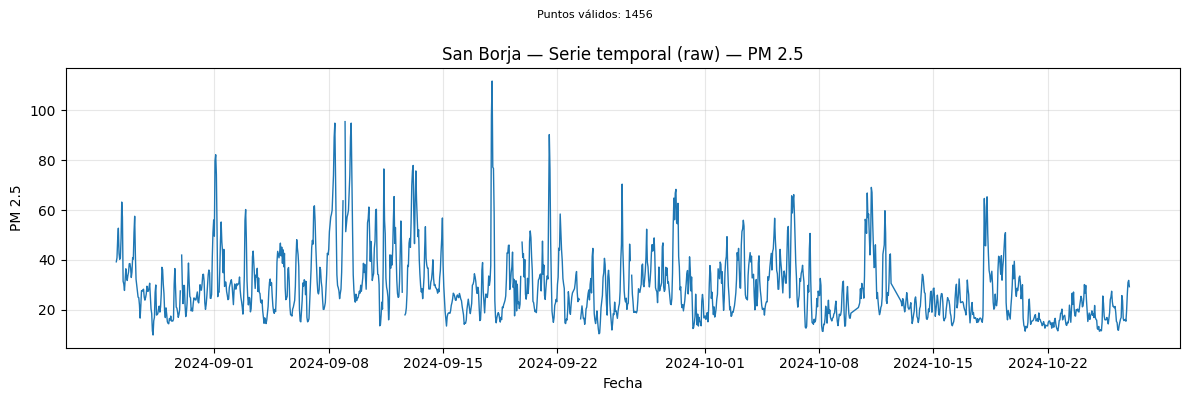

  Guardado plot: plots_raw_one_pollutant\San_Borja_PM_2.5_timeseries.png

Hecho. Se han generado los plots en la carpeta: plots_raw_one_pollutant


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

EXCEL_PATH = "Datos_Contaminación.xlsx"   # <- ajusta si hace falta
DATE_COL = "Fecha"
TIME_COL = "Hora"

# Cambia aquí el contaminante que quieres plotear (exacto como está en el Excel)
POLLUTANT = "PM 2.5"

OUT_DIR = "plots_raw_one_pollutant"
os.makedirs(OUT_DIR, exist_ok=True)

# leer todas las hojas
try:
    sheets = pd.read_excel(EXCEL_PATH, sheet_name=None, engine="openpyxl")
except Exception as e:
    raise SystemExit(f"Error leyendo {EXCEL_PATH}: {e}")

for sheet_name, df in sheets.items():
    print(f"\nProcesando hoja/estación: {sheet_name}")

    # Normalizar nombres y comprobar columnas
    df.columns = df.columns.str.strip()
    if DATE_COL not in df.columns or TIME_COL not in df.columns:
        print(f"  Saltando {sheet_name}: faltan columnas '{DATE_COL}' o '{TIME_COL}'")
        continue
    if POLLUTANT not in df.columns:
        print(f"  Saltando {sheet_name}: no está la columna '{POLLUTANT}'")
        continue

    # Combinar Fecha + Hora y parsear datetime
    combined = df[DATE_COL].astype(str).str.strip() + " " + df[TIME_COL].astype(str).str.strip()
    dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)  # intento día/mes/año
    # si muchos fallan, intentar otra forma
    if dt.isna().mean() > 0.2:
        dt_alt = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt_alt.isna().mean() < dt.isna().mean():
            dt = dt_alt

    df = df.copy()
    df['datetime'] = dt
    n_bad = df['datetime'].isna().sum()
    if n_bad:
        print(f"  Atención: {n_bad} filas sin datetime válido (se eliminarán para el plot).")
    df = df.dropna(subset=['datetime']).set_index('datetime').sort_index()

    # Convertir contaminante a número y contar valores válidos
    df[POLLUTANT] = pd.to_numeric(df[POLLUTANT], errors='coerce')
    n_nonnull = df[POLLUTANT].notna().sum()
    if n_nonnull == 0:
        print(f"  No hay valores numéricos para {POLLUTANT} en {sheet_name}.")
        continue

    # OPCIONAL: si hay demasiados puntos en la resolución original, puedes re-muestrear a 1H o 1D.
    # Para mostrar la serie tal cual comentada por el usuario, aquí dejamos la resolución original.
    # Si quisieras agregar resample: df_plot = df[POLLUTANT].resample('H').mean()

    # Plot: línea (serie temporal)
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df[POLLUTANT], linestyle='-', marker=None, linewidth=1)
    plt.title(f"{sheet_name} — Serie temporal (raw) — {POLLUTANT}")
    plt.xlabel("Fecha")
    plt.ylabel(POLLUTANT)
    plt.grid(alpha=0.3)

    # Información simple en el título/foot
    plt.suptitle(f"Puntos válidos: {n_nonnull}", y=0.99, fontsize=8)

    # Guardar PNG y mostrar (mostrar funciona bien en Jupyter)
    safe_name = "".join(c if c.isalnum() or c in "-_." else "_" for c in f"{sheet_name}_{POLLUTANT}")
    out_png = os.path.join(OUT_DIR, f"{safe_name}_timeseries.png")
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()
    plt.close()
    print(f"  Guardado plot: {out_png}")

print("\nHecho. Se han generado los plots en la carpeta:", OUT_DIR)


Comparando estaciones: Campo Marte y San Borja para el contaminante: PM 2.5


C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\912928020.py:27: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)  # asumimos día/mes/año
C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\912928020.py:27: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)  # asumimos día/mes/año


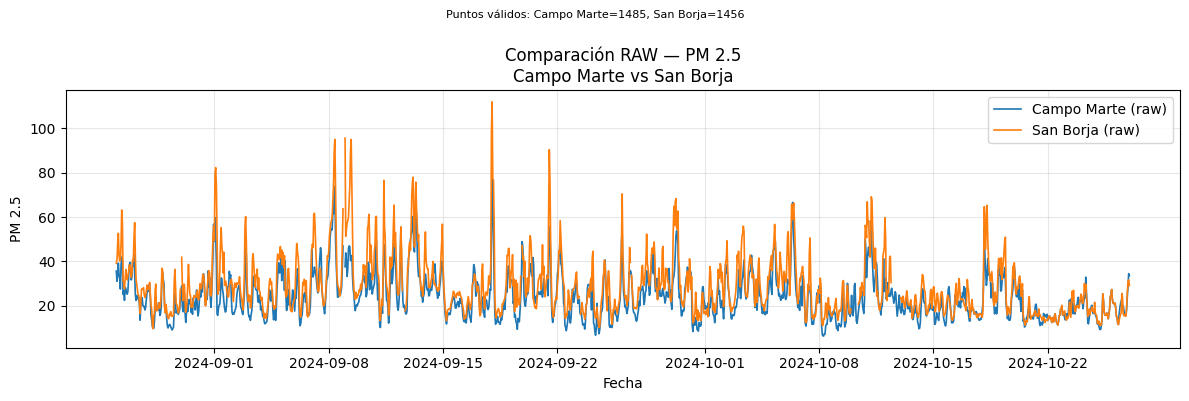

Comparación guardada en: plots_compare_two_raws\compare_raw_Campo_Marte_San_Borja_PM_2.5.png


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# CONFIGURACIÓN (cambia aquí)
# -------------------------
EXCEL_PATH = "Datos_Contaminación.xlsx"   # <-- pon aquí tu archivo
DATE_COL = "Fecha"
TIME_COL = "Hora"
POLLUTANT = "PM 2.5"                      # <-- contaminante a comparar

# Si quieres seleccionar estaciones específicas pon el nombre exacto de la hoja.
# Si dejas None, el script escogerá las dos primeras hojas del Excel automáticamente.
STATION_A = None
STATION_B = None

OUT_DIR = "plots_compare_two_raws"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------
# FUNCIONES AUXILIARES (sencillas)
# -------------------------
def parse_datetime(df, date_col, time_col):
    """Une fecha+hora y parsea a datetime; devuelve copia con columna 'datetime' parseada."""
    combined = df[date_col].astype(str).str.strip() + " " + df[time_col].astype(str).str.strip()
    dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)  # asumimos día/mes/año
    # si más del 20% falla, intentar otra interpretación
    if dt.isna().mean() > 0.2:
        dt_alt = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt_alt.isna().mean() < dt.isna().mean():
            dt = dt_alt
    df2 = df.copy()
    df2['datetime'] = dt
    df2 = df2.dropna(subset=['datetime']).set_index('datetime').sort_index()
    return df2

# -------------------------
# LECTURA DEL EXCEL
# -------------------------
try:
    all_sheets = pd.read_excel(EXCEL_PATH, sheet_name=None, engine="openpyxl")
except Exception as e:
    raise SystemExit(f"Error leyendo {EXCEL_PATH}: {e}")

sheet_names = list(all_sheets.keys())
if len(sheet_names) == 0:
    raise SystemExit("El Excel no contiene hojas.")

# seleccionar estaciones
if STATION_A is None or STATION_B is None:
    if len(sheet_names) < 2:
        raise SystemExit("Se necesitan al menos 2 hojas/estaciones en el Excel para comparar.")
    # tomar las dos primeras si no se especificaron
    if STATION_A is None:
        STATION_A = sheet_names[0]
    if STATION_B is None:
        STATION_B = sheet_names[1]

print("Comparando estaciones:", STATION_A, "y", STATION_B, "para el contaminante:", POLLUTANT)

# comprobar que las estaciones existan
if STATION_A not in all_sheets or STATION_B not in all_sheets:
    raise SystemExit("Una de las estaciones especificadas no existe en el Excel. Hojas disponibles: " + ", ".join(sheet_names))

# -------------------------
# PREPARAR SERIES RAW (sin modificar los datos)
# -------------------------
df_a_raw = all_sheets[STATION_A].copy()
df_b_raw = all_sheets[STATION_B].copy()

# comprobar columnas Fecha/Hora y la columna del contaminante
for name, df in [(STATION_A, df_a_raw), (STATION_B, df_b_raw)]:
    df.columns = df.columns.str.strip()  # limpiar espacios
    if DATE_COL not in df.columns or TIME_COL not in df.columns:
        raise SystemExit(f"La hoja '{name}' no tiene las columnas '{DATE_COL}' y/o '{TIME_COL}'.")
    if POLLUTANT not in df.columns:
        raise SystemExit(f"La hoja '{name}' no contiene la columna '{POLLUTANT}'.")

# parsear datetime y filtrar filas sin datetime válido
df_a = parse_datetime(df_a_raw, DATE_COL, TIME_COL)
df_b = parse_datetime(df_b_raw, DATE_COL, TIME_COL)

# convertir contaminante a num (NaN si no se puede)
df_a[POLLUTANT] = pd.to_numeric(df_a[POLLUTANT], errors='coerce')
df_b[POLLUTANT] = pd.to_numeric(df_b[POLLUTANT], errors='coerce')

n_a = df_a[POLLUTANT].notna().sum()
n_b = df_b[POLLUTANT].notna().sum()
if n_a == 0 or n_b == 0:
    raise SystemExit(f"No hay valores numéricos para {POLLUTANT} en una de las estaciones (n_a={n_a}, n_b={n_b}).")

# -------------------------
# Alinear índices temporales (unión) y preparar para plot
# -------------------------
# Usamos la unión de índices para que ambas series compartan la misma escala temporal en el plot.
idx_union = df_a.index.union(df_b.index).sort_values()
series_a = df_a[POLLUTANT].reindex(idx_union)
series_b = df_b[POLLUTANT].reindex(idx_union)

# -------------------------
# PLOT: ambas series en la misma figura (líneas)
# -------------------------
plt.figure(figsize=(12,4))
plt.plot(series_a.index, series_a.values, linestyle='-', linewidth=1.2, label=f"{STATION_A} (raw)")
plt.plot(series_b.index, series_b.values, linestyle='-', linewidth=1.2, label=f"{STATION_B} (raw)")
plt.title(f"Comparación RAW — {POLLUTANT}\n{STATION_A} vs {STATION_B}")
plt.xlabel("Fecha")
plt.ylabel(POLLUTANT)
plt.legend()
plt.grid(alpha=0.3)

# Información simple
plt.suptitle(f"Puntos válidos: {STATION_A}={n_a}, {STATION_B}={n_b}", y=0.99, fontsize=8)

# guardar y mostrar
out_name = f"compare_raw_{STATION_A}_{STATION_B}_{POLLUTANT}".replace(" ", "_").replace("/", "_")
out_path = os.path.join(OUT_DIR, out_name + ".png")
plt.tight_layout()
plt.savefig(out_path, dpi=150)
plt.show()
plt.close()

print("Comparación guardada en:", out_path)


In [8]:
# Interpolación simple para llenado de huecos (por estación / hoja)
# - Lee un Excel con varias hojas (cada hoja = estación)
# - Espera columnas: 'Fecha', 'Hora' y la columna del contaminante (POLLUTANT)
# - Para cada estación:
#     1) Cuenta cuántos NaN hay en el contaminante (antes)
#     2) Realiza interpolación temporal (method='time')
#     3) Cuenta cuántos NaN quedan después de interpolar
#     4) (Opcional) aplica ffill/bfill y cuenta cuántos quedan después
# - Guarda CSV con la serie original y la interpolada por estación y un resumen general.
#
# Diseñado para estudiantes principiantes: muchas impresiones y pasos explícitos.
# Requisitos: pandas, openpyxl (pip install pandas openpyxl)

import os
import pandas as pd

# -----------------------
# CONFIGURACIÓN (cambia según tu archivo)
# -----------------------
EXCEL_PATH = "Datos_Contaminación.xlsx"   # <- nombre del archivo Excel
DATE_COL = "Fecha"
TIME_COL = "Hora"
POLLUTANT = "PM 2.5"                      # <- cambiar por el contaminante que quieres trabajar
OUT_DIR = "interpolation_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------
# FUNCIONES AUXILIARES (simples)
# -----------------------
def parse_datetime(df, date_col, time_col):
    """Une fecha+hora y devuelve DatetimeIndex robusto (prueba dayfirst True/False)."""
    combined = df[date_col].astype(str).str.strip() + " " + df[time_col].astype(str).str.strip()
    dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)
    # fallback si muchos NaT
    if dt.isna().mean() > 0.2:
        dt_alt = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt_alt.isna().mean() < dt.isna().mean():
            dt = dt_alt
    return dt

# -----------------------
# LECTURA DEL EXCEL
# -----------------------
try:
    sheets = pd.read_excel(EXCEL_PATH, sheet_name=None, engine="openpyxl")
except Exception as e:
    raise SystemExit(f"Error leyendo {EXCEL_PATH}: {e}")

summary_rows = []  # acumulador de resúmenes por estación

for sheet_name, df_raw in sheets.items():
    print("\n=== Procesando estación/hoja:", sheet_name, "=== ")

    # Limpieza básica de nombres de columna
    df = df_raw.copy()
    df.columns = df.columns.str.strip()

    # Verificar columnas mínimas
    if DATE_COL not in df.columns or TIME_COL not in df.columns:
        print(f"  ERROR: La hoja '{sheet_name}' no contiene '{DATE_COL}' o '{TIME_COL}'. Saltando.")
        continue
    if POLLUTANT not in df.columns:
        print(f"  ERROR: La hoja '{sheet_name}' no contiene la columna '{POLLUTANT}'. Saltando.")
        continue

    # Parsear datetime y eliminar filas sin datetime válido
    dt = parse_datetime(df, DATE_COL, TIME_COL)
    df = df.copy()
    df['__datetime'] = dt
    n_no_dt = df['__datetime'].isna().sum()
    if n_no_dt > 0:
        print(f"  Atención: {n_no_dt} filas sin datetime válido (se eliminarán para el proceso).")
    df = df.dropna(subset=['__datetime']).set_index('__datetime').sort_index()

    # Consolidar timestamps duplicados (tomar media si hay registros con mismo datetime)
    if df.index.has_duplicates:
        print("  Aviso: hay timestamps duplicados. Se consolidarán (media sobre columnas numéricas).")
        numeric_cols = df.select_dtypes(include='number').columns.tolist()
        non_numeric = [c for c in df.columns if c not in numeric_cols]
        df_num = df[numeric_cols].groupby(level=0).mean()
        if non_numeric:
            df_nonnum = df[non_numeric].groupby(level=0).first()
            df = pd.concat([df_num, df_nonnum], axis=1)
        else:
            df = df_num

    # Asegurar columna numérica del contaminante
    df[POLLUTANT] = pd.to_numeric(df[POLLUTANT], errors='coerce')

    # Contar NaNs antes de cualquier operación
    total_points = len(df)
    n_missing_before = int(df[POLLUTANT].isna().sum())
    n_present_before = total_points - n_missing_before
    print(f"  Total filas (fecha/hora válidas): {total_points}")
    print(f"  Valores válidos antes de interpolar: {n_present_before}")
    print(f"  Valores faltantes antes de interpolar (NaN): {n_missing_before}")

    # Interpolación temporal (method='time')
    # Nota: interpolate(method='time') usa el índice datetime para interpolar en función del tiempo
    series_raw = df[POLLUTANT]
    series_interp = series_raw.interpolate(method='time')

    n_missing_after_interp = int(series_interp.isna().sum())
    n_filled_by_interp = n_missing_before - n_missing_after_interp
    pct_filled_by_interp = (n_filled_by_interp / n_missing_before * 100) if n_missing_before > 0 else 0.0

    print(f"  Valores faltantes después de interpolate(method='time'): {n_missing_after_interp}")
    print(f"  Valores completados por interpolación: {n_filled_by_interp}  ({pct_filled_by_interp:.1f}% de los faltantes)")

    # Opcional: rellenar extremos con forward/backward fill (si quieres que no queden NaN)
    # Aquí informamos ambas cifras (con y sin ffill/bfill).
    series_interp_ffill = series_interp.ffill().bfill()
    n_missing_after_ffill = int(series_interp_ffill.isna().sum())
    n_filled_by_ffill = n_missing_before - n_missing_after_ffill
    pct_filled_by_ffill = (n_filled_by_ffill / n_missing_before * 100) if n_missing_before > 0 else 0.0

    print(f"  Valores faltantes después de ffill/bfill: {n_missing_after_ffill}")
    print(f"  Valores completados (interp + ffill/bfill): {n_filled_by_ffill}  ({pct_filled_by_ffill:.1f}% de los faltantes)")

    # Guardar resultados en CSV (original vs interpolado vs interp+ffill)
    out_df = pd.DataFrame({
        'raw': series_raw,
        'interp_time': series_interp,
        'interp_time_ffill_bfill': series_interp_ffill
    }, index=df.index)
    safe_name = "".join(c if c.isalnum() or c in "-_." else "_" for c in f"{sheet_name}_{POLLUTANT}")
    out_csv = os.path.join(OUT_DIR, f"{safe_name}_interpolation.csv")
    out_df.to_csv(out_csv, index_label='datetime')
    print(f"  Guardado CSV con series raw/interp en: {out_csv}")

    # Añadir fila resumen para esta estación
    summary_rows.append({
        'station': sheet_name,
        'pollutant': POLLUTANT,
        'total_rows': int(total_points),
        'valid_before': int(n_present_before),
        'missing_before': int(n_missing_before),
        'missing_after_interp': int(n_missing_after_interp),
        'filled_by_interp': int(n_filled_by_interp),
        'pct_filled_by_interp': round(pct_filled_by_interp, 2),
        'missing_after_ffill': int(n_missing_after_ffill),
        'filled_by_interp_and_ffill': int(n_filled_by_ffill),
        'pct_filled_by_interp_and_ffill': round(pct_filled_by_ffill, 2),
        'out_csv': out_csv
    })

# -----------------------
# Guardar resumen general
# -----------------------
if summary_rows:
    summary_df = pd.DataFrame(summary_rows)
    summary_csv = os.path.join(OUT_DIR, f"interpolation_summary_{POLLUTANT.replace(' ','_')}.csv")
    summary_df.to_csv(summary_csv, index=False)
    print("\n--- Resumen general guardado en:", summary_csv)
    print(summary_df.to_string(index=False))
else:
    print("No se procesó ninguna hoja con éxito. Revisa el Excel y los nombres de columnas.")



=== Procesando estación/hoja: Campo Marte === 
  Total filas (fecha/hora válidas): 1488
  Valores válidos antes de interpolar: 1485
  Valores faltantes antes de interpolar (NaN): 3
  Valores faltantes después de interpolate(method='time'): 0
  Valores completados por interpolación: 3  (100.0% de los faltantes)
  Valores faltantes después de ffill/bfill: 0
  Valores completados (interp + ffill/bfill): 3  (100.0% de los faltantes)
  Guardado CSV con series raw/interp en: interpolation_outputs\Campo_Marte_PM_2.5_interpolation.csv

=== Procesando estación/hoja: San Borja === 
  Total filas (fecha/hora válidas): 1465
  Valores válidos antes de interpolar: 1456
  Valores faltantes antes de interpolar (NaN): 9
  Valores faltantes después de interpolate(method='time'): 0
  Valores completados por interpolación: 9  (100.0% de los faltantes)
  Valores faltantes después de ffill/bfill: 0
  Valores completados (interp + ffill/bfill): 9  (100.0% de los faltantes)
  Guardado CSV con series raw/inte

C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\3843757056.py:33: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)
C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\3843757056.py:33: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)



Procesando estación: Campo Marte
  Puntos válidos raw: 1485, faltantes antes: 3
  Pares para comparación (raw & interpolado): 1485
  Métricas (raw vs interpolado):
    N pares: 1485
    MAE: 0.000
    RMSE: 0.000
    Bias (raw - interp): 0.000
    R2: 1.000
    Pearson r: 1.000
    nRMSE (% of mean): 0.00%


C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\4205663803.py:18: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)


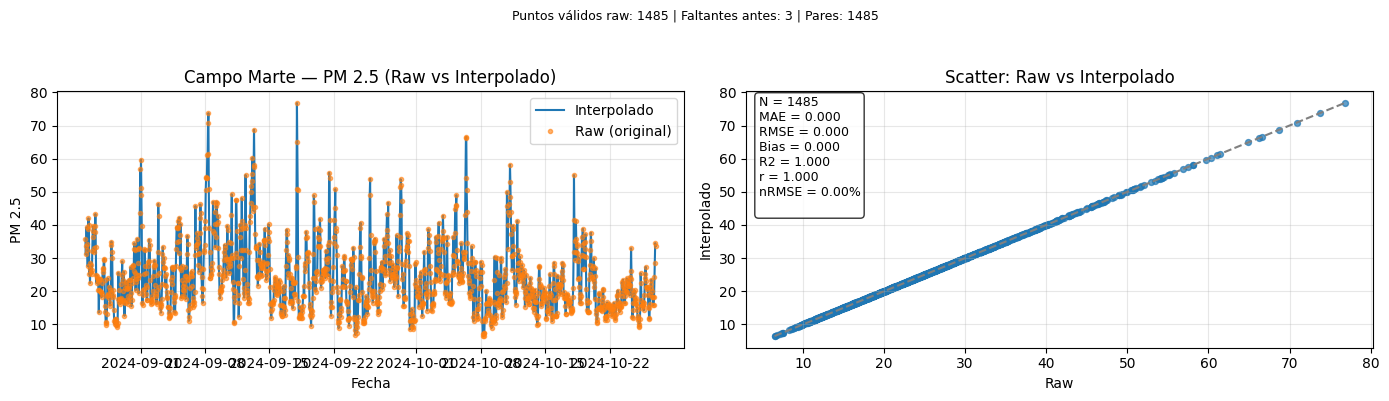

  Guardado: plots_raw_vs_interp_with_stats\Campo_Marte_PM_2.5_raw_vs_interp_stats.png

Procesando estación: San Borja
  Puntos válidos raw: 1456, faltantes antes: 9
  Pares para comparación (raw & interpolado): 1456
  Métricas (raw vs interpolado):
    N pares: 1456
    MAE: 0.000
    RMSE: 0.000
    Bias (raw - interp): 0.000
    R2: 1.000
    Pearson r: 1.000
    nRMSE (% of mean): 0.00%


C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\4205663803.py:18: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)


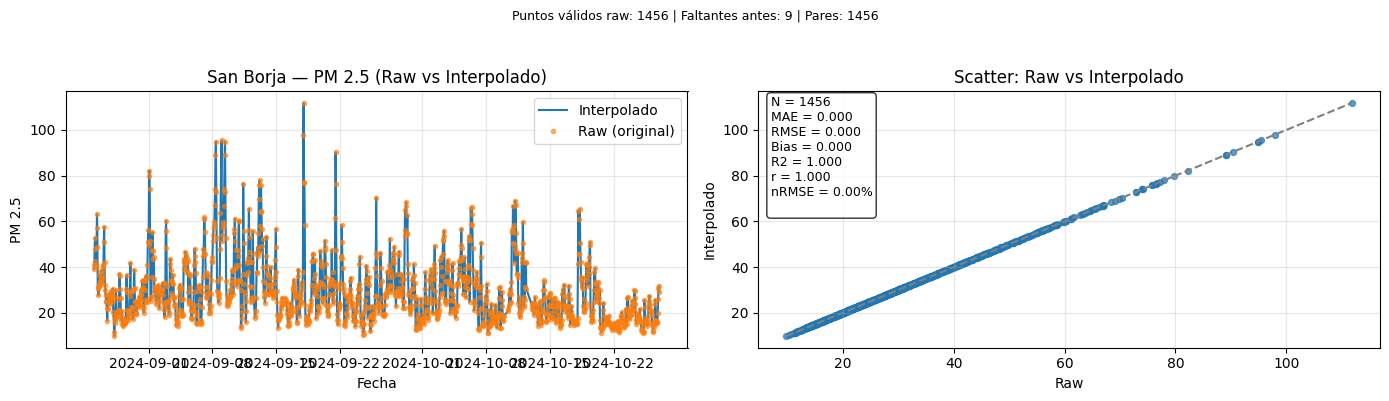

  Guardado: plots_raw_vs_interp_with_stats\San_Borja_PM_2.5_raw_vs_interp_stats.png

Proceso terminado. Plots y estadísticas guardadas en: plots_raw_vs_interp_with_stats


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- CONFIG --------
EXCEL_PATH = "Datos_Contaminación.xlsx"   # <- ajusta si hace falta
DATE_COL = "Fecha"
TIME_COL = "Hora"
POLLUTANT = "PM 2.5"                      # <- contaminante a evaluar
OUT_DIR = "plots_raw_vs_interp_with_stats"
os.makedirs(OUT_DIR, exist_ok=True)
# ------------------------

def parse_datetime(df, date_col, time_col):
    """Une Fecha+Hora e intenta parsear; devuelve DatetimeIndex (descarta filas sin datetime)."""
    combined = df[date_col].astype(str).str.strip() + " " + df[time_col].astype(str).str.strip()
    dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)
    if dt.isna().mean() > 0.2:
        dt_alt = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt_alt.isna().mean() < dt.isna().mean():
            dt = dt_alt
    return dt

def compute_error_metrics(y_true, y_pred):
    """
    Calcula métricas entre dos pandas.Series alineadas (sin NaN).
    Devuelve un diccionario con MAE, RMSE, bias, R2, r (pearson), n (n pares), nRMSE_pct.
    """
    # asegurar arrays numpy
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    n = len(y_true)
    if n == 0:
        return None
    err = y_true - y_pred
    mae = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    bias = np.mean(err)            # positivo => raw > interp en promedio
    # R2: 1 - SS_res/SS_tot
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan
    # Pearson r
    if n > 1:
        r = np.corrcoef(y_true, y_pred)[0,1]
    else:
        r = np.nan
    # normalized RMSE (por media de y_true) en %
    mean_true = np.mean(y_true)
    nrmse_pct = (rmse / mean_true * 100) if mean_true != 0 else np.nan

    return {
        'n': int(n),
        'MAE': float(mae),
        'RMSE': float(rmse),
        'Bias (mean raw - interp)': float(bias),
        'R2': float(r2) if not np.isnan(r2) else r2,
        'Pearson r': float(r) if not np.isnan(r) else r,
        'nRMSE_pct': float(nrmse_pct) if not np.isnan(nrmse_pct) else nrmse_pct
    }

# leer todo el Excel (cada hoja -> estación)
try:
    sheets = pd.read_excel(EXCEL_PATH, sheet_name=None, engine="openpyxl")
except Exception as e:
    raise SystemExit(f"Error leyendo {EXCEL_PATH}: {e}")

for station_name, df_raw in sheets.items():
    print(f"\nProcesando estación: {station_name}")

    # limpiar columnas y verificar
    df = df_raw.copy()
    df.columns = df.columns.str.strip()
    if DATE_COL not in df.columns or TIME_COL not in df.columns:
        print(f"  Saltando {station_name}: faltan '{DATE_COL}' o '{TIME_COL}'")
        continue
    if POLLUTANT not in df.columns:
        print(f"  Saltando {station_name}: no existe la columna '{POLLUTANT}'")
        continue

    # parsear datetime y eliminar filas sin datetime válido
    dt = parse_datetime(df, DATE_COL, TIME_COL)
    df = df.copy()
    df['__datetime'] = dt
    n_no_dt = int(df['__datetime'].isna().sum())
    if n_no_dt:
        print(f"  Atención: {n_no_dt} filas sin datetime válido (se descartarán).")
    df = df.dropna(subset=['__datetime']).set_index('__datetime').sort_index()

    # convertir contaminante a numérico
    df[POLLUTANT] = pd.to_numeric(df[POLLUTANT], errors='coerce')

    # Preparar series raw e interpolada (interpolación por tiempo)
    series_raw = df[POLLUTANT].copy()
    series_interp = series_raw.interpolate(method='time')

    # Pares donde ambos existen para comparar
    idx_union = series_raw.index.union(series_interp.index)
    raw_reindexed = series_raw.reindex(idx_union)
    interp_reindexed = series_interp.reindex(idx_union)
    mask_both = raw_reindexed.notna() & interp_reindexed.notna()
    n_pairs = int(mask_both.sum())
    print(f"  Puntos válidos raw: {int(series_raw.notna().sum())}, faltantes antes: {int(series_raw.isna().sum())}")
    print(f"  Pares para comparación (raw & interpolado): {n_pairs}")

    # Calcular métricas
    metrics = compute_error_metrics(raw_reindexed[mask_both], interp_reindexed[mask_both])
    if metrics is None:
        print("  No hay pares para calcular métricas. Saltando plot de métricas.")
    else:
        # imprimir métricas en consola (útil en clase)
        print("  Métricas (raw vs interpolado):")
        print(f"    N pares: {metrics['n']}")
        print(f"    MAE: {metrics['MAE']:.3f}")
        print(f"    RMSE: {metrics['RMSE']:.3f}")
        print(f"    Bias (raw - interp): {metrics['Bias (mean raw - interp)']:.3f}")
        print(f"    R2: {metrics['R2']:.3f}")
        print(f"    Pearson r: {metrics['Pearson r']:.3f}")
        if not np.isnan(metrics['nRMSE_pct']):
            print(f"    nRMSE (% of mean): {metrics['nRMSE_pct']:.2f}%")
        else:
            print("    nRMSE: NA (mean raw = 0)")

    # ---- Plot ----
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

    # Serie temporal: interpolado (línea) + raw (puntos)
    ax1.plot(interp_reindexed.index, interp_reindexed.values, linestyle='-', linewidth=1.5, label='Interpolado')
    ax1.plot(raw_reindexed.index, raw_reindexed.values, linestyle='None', marker='o', markersize=3, alpha=0.6, label='Raw (original)')
    ax1.set_title(f"{station_name} — {POLLUTANT} (Raw vs Interpolado)")
    ax1.set_xlabel("Fecha")
    ax1.set_ylabel(POLLUTANT)
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Scatter raw vs interpolado (solo donde ambos existan)
    if n_pairs > 0:
        x = raw_reindexed[mask_both]
        y = interp_reindexed[mask_both]
        ax2.scatter(x, y, s=18, alpha=0.7)
        mn = min(x.min(), y.min())
        mx = max(x.max(), y.max())
        ax2.plot([mn, mx], [mn, mx], linestyle='--', color='gray')  # línea 1:1
        ax2.set_xlim(mn - 0.05*(mx-mn if mx>mn else 1), mx + 0.05*(mx-mn if mx>mn else 1))
        ax2.set_ylim(mn - 0.05*(mx-mn if mx>mn else 1), mx + 0.05*(mx-mn if mx>mn else 1))
    else:
        ax2.text(0.5, 0.5, "No hay pares (raw, interpolado) para comparar", ha='center', va='center')

    ax2.set_title("Scatter: Raw vs Interpolado")
    ax2.set_xlabel("Raw")
    ax2.set_ylabel("Interpolado")
    ax2.grid(alpha=0.3)

    # Añadir recuadro con estadísticas en el panel scatter (ajustable y fácil de leer)
    if metrics is not None:
        stats_text = (
            f"N = {metrics['n']}\n"
            f"MAE = {metrics['MAE']:.3f}\n"
            f"RMSE = {metrics['RMSE']:.3f}\n"
            f"Bias = {metrics['Bias (mean raw - interp)']:.3f}\n"
            f"R2 = {metrics['R2']:.3f}\n"
            f"r = {metrics['Pearson r']:.3f}\n"
        )
        if not np.isnan(metrics['nRMSE_pct']):
            stats_text += f"nRMSE = {metrics['nRMSE_pct']:.2f}%\n"
        else:
            stats_text += "nRMSE = NA\n"

        # colocar el texto dentro de una caja en ax2
        ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, fontsize=9,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Información general en el título/figura
    subtitle = f"Puntos válidos raw: {int(series_raw.notna().sum())} | Faltantes antes: {int(series_raw.isna().sum())} | Pares: {n_pairs}"
    fig.suptitle(subtitle, fontsize=9, y=0.99)

    plt.tight_layout(rect=[0,0,1,0.95])

    # guardar y mostrar
    safe = "".join(c if c.isalnum() or c in "-_." else "_" for c in f"{station_name}_{POLLUTANT}_raw_vs_interp_stats")
    out_png = os.path.join(OUT_DIR, f"{safe}.png")
    fig.savefig(out_png, dpi=150)
    plt.show()
    plt.close(fig)
    print(f"  Guardado: {out_png}")

print("\nProceso terminado. Plots y estadísticas guardadas en:", OUT_DIR)



Hojas/estaciones disponibles en el Excel:
   1. Campo_De_Marte_MET_EMA
   2. Carabayllo_MET_EMA
   3. Ceres_MET_EMA
   4. Las_Palmas_MET_EMA
   5. Pantanos_De_Villa_MET_EMA
   6. San_Borja_MET_EMA
   7. San_Martin_De_Porres_MET_EAA


Se graficará la variable: 'TEMPERATURA (°C)'
Estación(es) seleccionada(s): Pantanos_De_Villa_MET_EMA

Procesando estación: Pantanos_De_Villa_MET_EMA
  Filas con datetime válidas: 27899  |  Valores válidos: 26977  |  Faltantes: 922


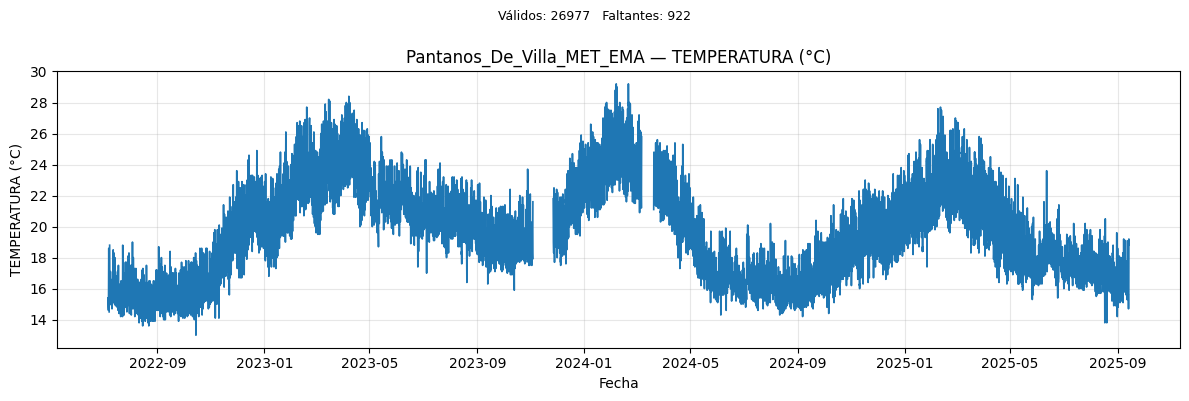

  Plot guardado en: plots_variable_elegida_interactive\Pantanos_De_Villa_MET_EMA__TEMPERATURA___C__raw.png

Proceso terminado. Los plots (si se generaron) están en: plots_variable_elegida_interactive


In [11]:
# Plot interactivo (por consola) para elegir estación y plotear UNA variable meteorológica.
# - Muestra la lista de hojas/estaciones del Excel
# - Permite elegir por número o por nombre (o 'all' para todas)
# - Plotea la VARIABLE elegida (configurable abajo) para la estación seleccionada
#
# Diseñado para usuarios principiantes: sin interfaces gráficas, solo input() en consola/Jupyter.
# Requisitos: pandas, matplotlib, openpyxl

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ CONFIG (edita si quieres valores por defecto) ------------------
EXCEL_PATH = "senamhi_by_station.xlsx"   # <- pon tu archivo aquí (mismo que usaste)
DATE_COL = "AÑO / MES / DÍA"
TIME_COL = "HORA"

# Nombre exacto de la columna que quieres plotear por defecto (puedes cambiarlo en la ejecución)
VARIABLE_DEFAULT = "TEMPERATURA (°C)"

# Opcional: remuestreo antes de plotear (None, 'H' o 'D')
RESAMPLE_RULE = None

OUT_DIR = "plots_variable_elegida_interactive"
os.makedirs(OUT_DIR, exist_ok=True)
# -----------------------------------------------------------------------------------

def safe_parse_datetime(fecha_ser, hora_ser):
    """Parseo robusto fecha+hora; retorna DatetimeIndex (NaT donde no pudo)."""
    combined = fecha_ser.astype(str).str.strip() + " " + hora_ser.astype(str).str.strip()
    dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)
    if dt.isna().mean() > 0.2:
        dt_alt = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt_alt.isna().mean() < dt.isna().mean():
            dt = dt_alt
    times_lower = hora_ser.astype(str).str.lower()
    if dt.isna().mean() > 0.2 and times_lower.str.contains('am|pm').any():
        dt_alt2 = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt_alt2.isna().mean() < dt.isna().mean():
            dt = dt_alt2
    return dt

# Leer Excel (todas las hojas)
try:
    sheets = pd.read_excel(EXCEL_PATH, sheet_name=None, engine="openpyxl")
except Exception as e:
    raise SystemExit(f"Error leyendo '{EXCEL_PATH}': {e}")

sheet_names = list(sheets.keys())
if not sheet_names:
    raise SystemExit("El Excel no contiene hojas/estaciones.")

# Imprimir la lista de hojas/estaciones
print("\nHojas/estaciones disponibles en el Excel:")
for i, name in enumerate(sheet_names, start=1):
    print(f"  {i:2d}. {name}")
print()

# Pedir al usuario que elija estación (por número, por nombre, o 'all')
choice = input("Elige estación por número, por nombre exacto, o escribe 'all' para todas: ").strip()
if not choice:
    print("No ingresaste nada. Saliendo.")
    sys.exit(0)

if choice.lower() == 'all':
    selected = sheet_names[:]  # todas
else:
    # intentar interpretar como número
    selected = []
    if choice.isdigit():
        idx = int(choice) - 1
        if 0 <= idx < len(sheet_names):
            selected = [sheet_names[idx]]
        else:
            print("Número fuera de rango. Saliendo.")
            sys.exit(1)
    else:
        # buscar nombre exacto
        if choice in sheet_names:
            selected = [choice]
        else:
            print("No se encontró la hoja con ese nombre. Salir.")
            sys.exit(1)

# Preguntar qué variable plotear (dejar valor por defecto si el usuario sólo presiona Enter)
var_input = input(f"Escribe el nombre EXACTO de la variable a plotear (Enter = '{VARIABLE_DEFAULT}'): ").strip()
VARIABLE = var_input if var_input else VARIABLE_DEFAULT

# Confirmar y proceder
print(f"\nSe graficará la variable: '{VARIABLE}'")
print("Estación(es) seleccionada(s):", ", ".join(selected))
print()

# Procesar cada estación seleccionada
for station_name in selected:
    print(f"Procesando estación: {station_name}")

    df_raw = sheets[station_name].copy()
    df_raw.columns = df_raw.columns.str.strip()

    # Comprobaciones mínimas
    if DATE_COL not in df_raw.columns or TIME_COL not in df_raw.columns:
        print(f"  ERROR: la hoja '{station_name}' no contiene las columnas '{DATE_COL}' y/o '{TIME_COL}'. Se salta.")
        continue
    if VARIABLE not in df_raw.columns:
        print(f"  ERROR: la hoja '{station_name}' no contiene la columna '{VARIABLE}'. Se salta.")
        continue

    # Parsear datetime
    dt = safe_parse_datetime(df_raw[DATE_COL], df_raw[TIME_COL])
    df = df_raw.copy()
    df['__datetime'] = dt
    n_no_dt = int(df['__datetime'].isna().sum())
    if n_no_dt > 0:
        print(f"  Atención: {n_no_dt} filas sin datetime válido (se eliminarán).")
    df = df.dropna(subset=['__datetime']).set_index('__datetime').sort_index()

    # Convertir a numérico la variable seleccionada
    df[VARIABLE] = pd.to_numeric(df[VARIABLE], errors='coerce')

    total_rows = len(df)
    n_valid = int(df[VARIABLE].notna().sum())
    n_missing = int(df[VARIABLE].isna().sum())
    print(f"  Filas con datetime válidas: {total_rows}  |  Valores válidos: {n_valid}  |  Faltantes: {n_missing}")

    if n_valid == 0:
        print(f"  No hay valores numéricos para '{VARIABLE}' en '{station_name}'. Se omite.")
        continue

    # Aplicar remuestreo (si se especificó en CONFIG)
    if RESAMPLE_RULE:
        series_plot = df[VARIABLE].resample(RESAMPLE_RULE).mean()
        info_resample = f" (resampled {RESAMPLE_RULE})"
    else:
        series_plot = df[VARIABLE]
        info_resample = ""

    # Plot simple en línea
    plt.figure(figsize=(12,4))
    plt.plot(series_plot.index, series_plot.values, linestyle='-', linewidth=1.2)
    plt.title(f"{station_name} — {VARIABLE}{info_resample}")
    plt.xlabel("Fecha")
    plt.ylabel(VARIABLE)
    plt.grid(alpha=0.3)
    plt.suptitle(f"Válidos: {n_valid}   Faltantes: {n_missing}", y=0.99, fontsize=9)

    # Guardar y mostrar
    safe_station = "".join(c if c.isalnum() or c in "-_." else "_" for c in station_name)
    safe_var = "".join(c if c.isalnum() or c in "-_." else "_" for c in VARIABLE)
    suffix = f"_{RESAMPLE_RULE}" if RESAMPLE_RULE else ""
    out_png = os.path.join(OUT_DIR, f"{safe_station}__{safe_var}{suffix}_raw.png")
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()
    plt.close()
    print(f"  Plot guardado en: {out_png}\n")

print("Proceso terminado. Los plots (si se generaron) están en:", OUT_DIR)



Selecciona la estación (hoja) que quieres analizar:
   1. Campo_De_Marte_MET_EMA
   2. Carabayllo_MET_EMA
   3. Ceres_MET_EMA
   4. Las_Palmas_MET_EMA
   5. Pantanos_De_Villa_MET_EMA
   6. San_Borja_MET_EMA
   7. San_Martin_De_Porres_MET_EAA

Variables candidatas (valores numéricos = n):
   1. TEMPERATURA (°C)  (n = 26977)
   2. HUMEDAD (%)  (n = 26977)
   3. DIRECCION DEL VIENTO (°)  (n = 23312)
   4. VELOCIDAD DEL VIENTO (m/s)  (n = 26979)

Elige periodo a analizar:
  1. Total (todo el rango disponible)
  2. Un año específico (ej. 2020)
Entrada inválida. Intenta de nuevo.

Elige periodo a analizar:
  1. Total (todo el rango disponible)
  2. Un año específico (ej. 2020)
Entrada inválida. Intenta de nuevo.

Elige periodo a analizar:
  1. Total (todo el rango disponible)
  2. Un año específico (ej. 2020)
Entrada inválida. Intenta de nuevo.

Elige periodo a analizar:
  1. Total (todo el rango disponible)
  2. Un año específico (ej. 2020)
No hay datos del año 2019 en esta estación (rango

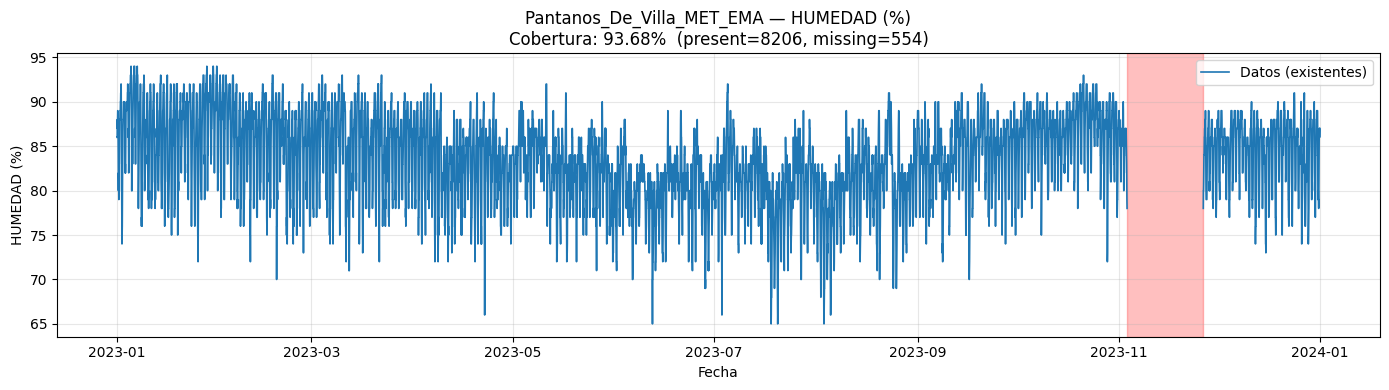


Plot guardado en: plots_coverage_with_shading\Pantanos_De_Villa_MET_EMA__HUMEDAD_____coverage_plot.png

Hecho. Si quieres que el sombreado muestre además texto con % por bloque (o que use otro color/alpha), lo ajusto.


In [12]:
# Resumen interactivo + plots (datos existentes en azul, zonas faltantes sombreadas en rojo)
# - Menús por número para escoger estación y variable (filtrado automático)
# - Elegir periodo: total o un año
# - Muestra tablas en pantalla: resumen general, cobertura mensual y por hora
# - Dibuja una serie temporal con:
#     * línea azul donde hay datos
#     * sombreado rojo en los intervalos faltantes
# - Muestra la figura y además la guarda en OUT_DIR (opcional)
#
# Diseñado para estudiantes principiantes: entradas sencillas, prints claros y código comentado.
# Requisitos: pandas, numpy, matplotlib, openpyxl
# Copiar/pegar en Jupyter o ejecutar en un .py

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
EXCEL_PATH = "senamhi_by_station.xlsx"
DATE_COL = "AÑO / MES / DÍA"
TIME_COL = "HORA"
OUT_DIR = "plots_coverage_with_shading"
os.makedirs(OUT_DIR, exist_ok=True)
# ----------------------------------------

def safe_parse_datetime(fecha_ser, hora_ser):
    combined = fecha_ser.astype(str).str.strip() + " " + hora_ser.astype(str).str.strip()
    dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)
    if dt.isna().mean() > 0.2:
        dt_alt = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt_alt.isna().mean() < dt.isna().mean():
            dt = dt_alt
    return dt

def choose_from_list(options, prompt):
    if not options:
        return None
    while True:
        print("\n" + prompt)
        for i, opt in enumerate(options, 1):
            print(f"  {i:2d}. {opt}")
        choice = input("Elige por número (o 'q' para salir): ").strip()
        if choice.lower() == 'q':
            return None
        if choice.isdigit():
            idx = int(choice) - 1
            if 0 <= idx < len(options):
                return options[idx]
        print("Entrada no válida. Intenta otra vez.")

def is_datetime_like(col):
    n = col.lower()
    for p in ['fecha','hora','año','ano','mes','dia','día','time','date','year','day']:
        if p in n:
            return True
    return False

# Leer Excel
try:
    sheets = pd.read_excel(EXCEL_PATH, sheet_name=None, engine="openpyxl")
except Exception as e:
    raise SystemExit(f"Error leyendo '{EXCEL_PATH}': {e}")

sheet_names = list(sheets.keys())
if not sheet_names:
    raise SystemExit("El Excel no contiene hojas/estaciones.")

# Seleccionar estación
station = choose_from_list(sheet_names, "Selecciona la estación (hoja) que quieres analizar:")
if station is None:
    sys.exit("Cancelado por el usuario.")

df_raw = sheets[station].copy()
df_raw.columns = df_raw.columns.str.strip()

# Construir lista de variables candidatas (excluir fecha/hora)
cols = [c for c in df_raw.columns if c not in (DATE_COL, TIME_COL) and not is_datetime_like(c)]
cand = []
for c in cols:
    nnum = pd.to_numeric(df_raw[c], errors='coerce').notna().sum()
    cand.append((c, int(nnum)))
if not cand:
    cand = [(c,0) for c in cols]

# Elegir variable mostrando conteos
while True:
    print("\nVariables candidatas (valores numéricos = n):")
    for i, (c, nnum) in enumerate(cand, 1):
        print(f"  {i:2d}. {c}  (n = {nnum})")
    ch = input("Elige variable por número (o 'q' para salir): ").strip()
    if ch.lower() == 'q':
        sys.exit("Cancelado.")
    if ch.isdigit():
        idx = int(ch) - 1
        if 0 <= idx < len(cand):
            var = cand[idx][0]
            break
    print("Entrada inválida. Intenta de nuevo.")

# Parsear datetime
if DATE_COL not in df_raw.columns or TIME_COL not in df_raw.columns:
    raise SystemExit(f"Faltan columnas de fecha/hora ({DATE_COL}/{TIME_COL}) en la hoja seleccionada.")

dt = safe_parse_datetime(df_raw[DATE_COL], df_raw[TIME_COL])
df = df_raw.copy()
df['__dt'] = dt
n_bad = int(df['__dt'].isna().sum())
if n_bad > 0:
    print(f"\nAviso: {n_bad} filas no pudieron parsearse como datetime y se ignorarán.")
df = df.dropna(subset=['__dt']).set_index('__dt').sort_index()
if df.shape[0] == 0:
    raise SystemExit("No hay filas con datetime válido en la hoja seleccionada.")

# Elegir periodo (total o año) robusto
while True:
    print("\nElige periodo a analizar:")
    print("  1. Total (todo el rango disponible)")
    print("  2. Un año específico (ej. 2020)")
    p = input("Escribe 1 ó 2 (o 'q' para salir): ").strip()
    if p.lower() == 'q':
        sys.exit("Cancelado.")
    if p == '1':
        start = df.index.min().floor('h')
        end = df.index.max().ceil('h')
        break
    if p == '2':
        y = input("Escribe el año (YYYY): ").strip()
        if y.lower() == 'q':
            sys.exit("Cancelado.")
        try:
            year = int(y)
        except:
            print("Año inválido. Intenta otra vez.")
            continue
        year_start = pd.Timestamp(year=year, month=1, day=1, hour=0)
        year_end = pd.Timestamp(year=year, month=12, day=31, hour=23)
        data_min = df.index.min(); data_max = df.index.max()
        if year_end < data_min or year_start > data_max:
            print(f"No hay datos del año {year} en esta estación (rango: {data_min.date()} - {data_max.date()}). Elige otro año.")
            continue
        start = max(year_start, data_min.floor('h'))
        end = min(year_end, data_max.ceil('h'))
        break
    print("Entrada inválida. Intenta de nuevo.")

# Índice horario continuo
full_idx = pd.date_range(start=start, end=end, freq='h')
n_total = len(full_idx)

# Preparar serie y reindex
df[var] = pd.to_numeric(df[var], errors='coerce')
df_period = df.loc[(df.index >= start) & (df.index <= end)].copy()
series = df_period[var].reindex(full_idx)

# Resumen general
n_present = int(series.notna().sum())
n_missing = int(series.isna().sum())
coverage = n_present / n_total * 100 if n_total > 0 else np.nan
print("\n--- RESUMEN GENERAL ---")
print(f"Estación: {station}")
print(f"Variable : {var}")
print(f"Periodo  : {start}  a  {end}   (horas = {n_total})")
print(f"Filas originales dentro del periodo: {int(df_period.shape[0])}")
print(f"Horas con dato   : {n_present}")
print(f"Horas faltantes  : {n_missing}")
print(f"Cobertura (%)    : {coverage:.2f}%")

# Tabla mensual (impresa)
tbl = series.to_frame(name='value')
tbl['present'] = tbl['value'].notna().astype(int)
tbl['month'] = tbl.index.to_period('M')
month_summary = tbl.groupby('month')['present'].agg(['sum','count']).rename(columns={'sum':'present','count':'total'})
month_summary['missing'] = month_summary['total'] - month_summary['present']
month_summary['coverage_pct'] = (month_summary['present'] / month_summary['total'] * 100).round(2)
month_summary_print = month_summary.reset_index()
month_summary_print['month'] = month_summary_print['month'].astype(str)
print("\n--- Cobertura mensual ---")
print(month_summary_print.to_string(index=False))

# Tabla por hora del día (0..23)
tbl_hour = tbl.copy()
tbl_hour['hour'] = tbl_hour.index.hour
hour_summary = tbl_hour.groupby('hour')['present'].agg(['sum','count']).rename(columns={'sum':'present','count':'total'})
hour_summary['missing'] = hour_summary['total'] - hour_summary['present']
hour_summary['coverage_pct'] = (hour_summary['present'] / hour_summary['total'] * 100).round(2)
print("\n--- Cobertura por hora del día (0..23) ---")
print(hour_summary.reset_index().to_string(index=False))

# --- PLOT: serie temporal con sombreado rojo en huecos ---
fig, ax = plt.subplots(figsize=(14,4))

# Plot de la serie (línea azul donde hay dato)
ax.plot(series.index, series.values, linestyle='-', linewidth=1.2, color='tab:blue', label='Datos (existentes)')

# Encontrar bloques contiguos de NaN para sombrear
is_nan = series.isna()
if is_nan.all():
    # todo faltante -> sombrear todo el rango
    ax.axvspan(series.index[0], series.index[-1], color='red', alpha=0.25)
else:
    # detectar cambios en is_nan para identificar intervalos
    nan_groups = (is_nan != is_nan.shift(1)).cumsum()
    grouped = series.groupby(nan_groups)
    for _, g in grouped:
        if g.isna().all():
            start_nan = g.index[0]
            end_nan = g.index[-1] + pd.Timedelta(hours=1)  # extender hasta el final de la última hora
            ax.axvspan(start_nan, end_nan, color='red', alpha=0.25)

# Mejoras estéticas
ax.set_title(f"{station} — {var}\nCobertura: {coverage:.2f}%  (present={n_present}, missing={n_missing})")
ax.set_xlabel("Fecha")
ax.set_ylabel(var)
ax.grid(alpha=0.3)
ax.legend(loc='upper right')

plt.tight_layout()

# Mostrar y guardar la figura
plt.show()

# Guardar figura (opcional)
safe_station = "".join(ch if ch.isalnum() or ch in "-_." else "_" for ch in station)
safe_var = "".join(ch if ch.isalnum() or ch in "-_." else "_" for ch in var)
fname = f"{safe_station}__{safe_var}_coverage_plot.png"
outpath = os.path.join(OUT_DIR, fname)
fig.savefig(outpath, dpi=150)
print(f"\nPlot guardado en: {outpath}")

print("\nHecho. Si quieres que el sombreado muestre además texto con % por bloque (o que use otro color/alpha), lo ajusto.")



Selecciona la estación (hoja) que quieres procesar:
   1. Campo_De_Marte_MET_EMA
   2. Carabayllo_MET_EMA
   3. Ceres_MET_EMA
   4. Las_Palmas_MET_EMA
   5. Pantanos_De_Villa_MET_EMA
   6. San_Borja_MET_EMA
   7. San_Martin_De_Porres_MET_EAA

Elige periodo a procesar:
  1. Total (todo el rango disponible)
  2. Un año específico (ej. 2020)

Periodo: 2020-10-01 00:00:00 a 2025-09-13 12:00:00  (horas = 43405)
Antes del llenado: válidos=43060  faltantes=345

Resumen de llenado:
  Interpolación (≤ 3 h): 146
  Climatología (largos): 199
  Fallback ffill/bfill: 0
  Válidos después del llenado: 43405  Faltantes restantes: 0

--- ESTADÍSTICOS RESUMIDOS ---
Originales (solo observados): {'n': 43060, 'mean': 19.166869484440316, 'median': 18.8, 'std': 3.4763767207457055, 'min': 12.1, 'max': 33.7}
Rellenados (solo los puntos imputados): {'n': 345, 'mean': 18.575440186395607, 'median': 18.246914952751528, 'std': 2.7110167368772484, 'min': 13.100000000000001, 'max': 27.45}
Serie completa (original +

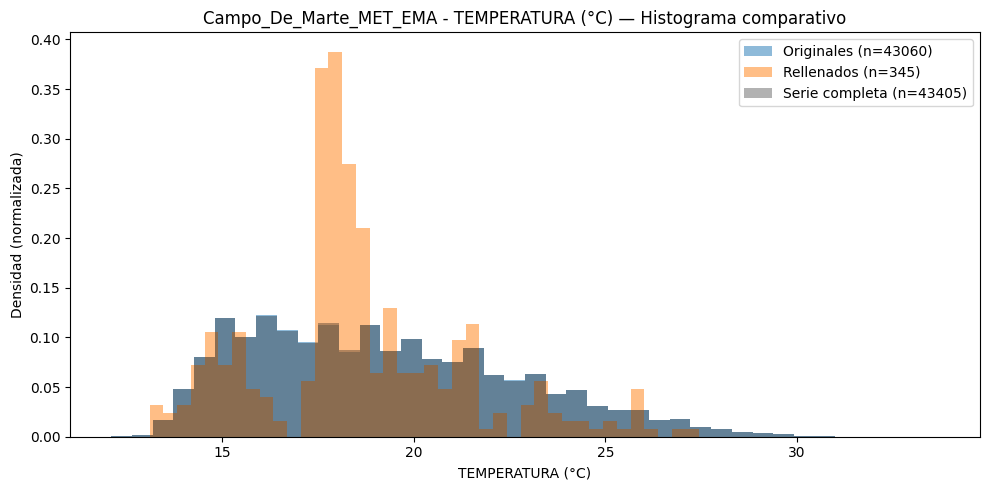

Guardado: comparativas_rellenos_vs_full_vs_original_separated\Campo_De_Marte_MET_EMA_comparative_hist.png


C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\2436939972.py:254: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels, showfliers=True)


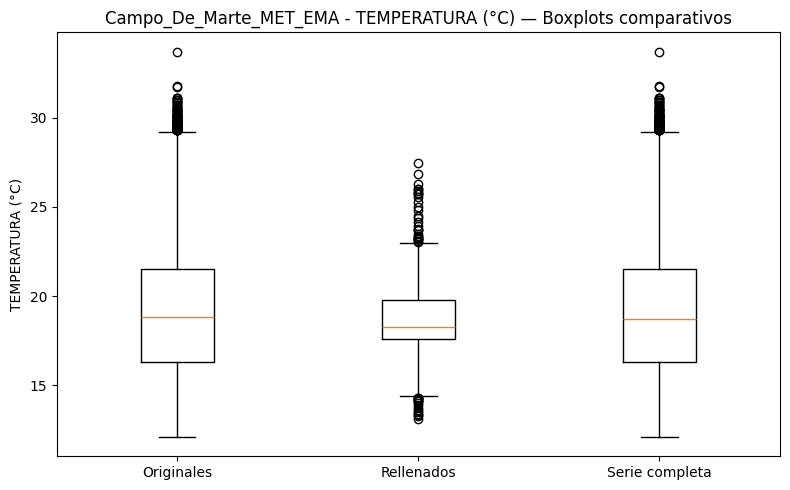

Guardado: comparativas_rellenos_vs_full_vs_original_separated\Campo_De_Marte_MET_EMA_comparative_boxplots.png


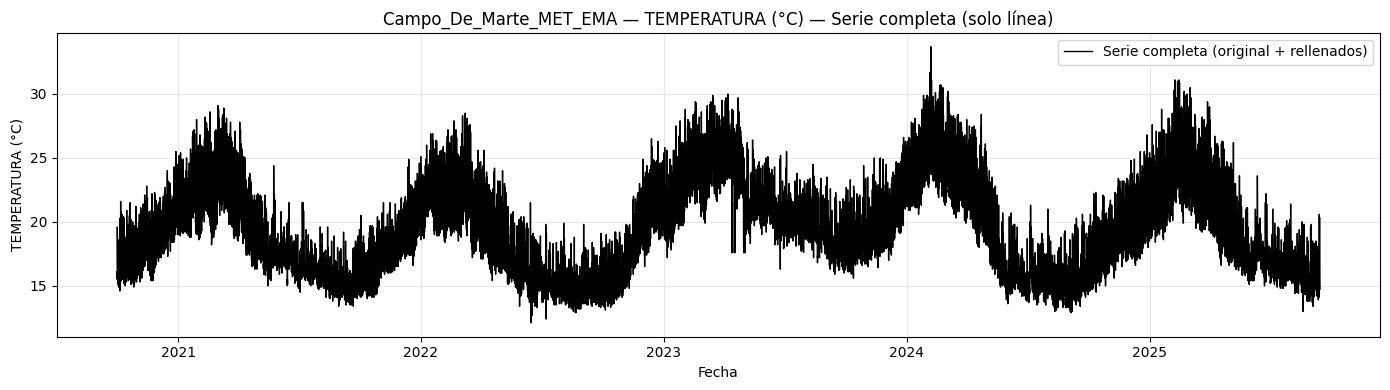

Guardado: comparativas_rellenos_vs_full_vs_original_separated\Campo_De_Marte_MET_EMA_series_complete_only.png


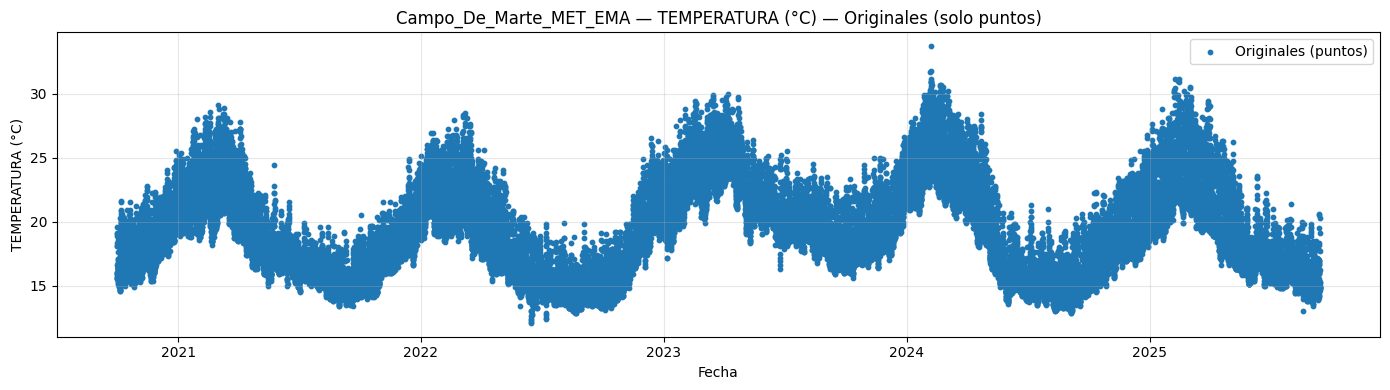

Guardado: comparativas_rellenos_vs_full_vs_original_separated\Campo_De_Marte_MET_EMA_originals_only.png


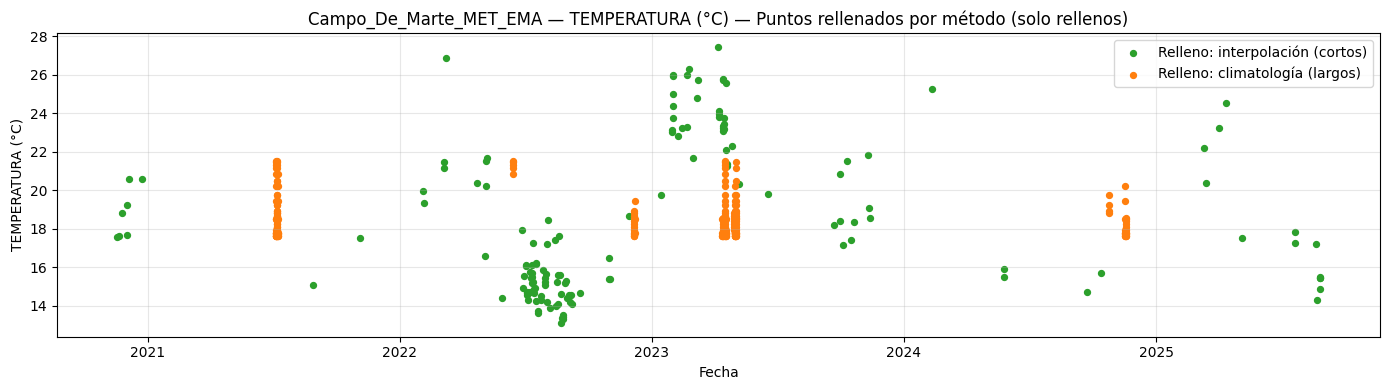

Guardado: comparativas_rellenos_vs_full_vs_original_separated\Campo_De_Marte_MET_EMA_filled_points_only.png

--- TABLA RESUMEN COMPARATIVA (compacta) ---
Categoria                           n       mean     median        std
Originales                      43060     19.167     18.800      3.476
Rellenados (solo imputados)       345     18.575     18.247      2.711
Serie completa (orig + rellenos)  43405     19.162     18.700      3.471


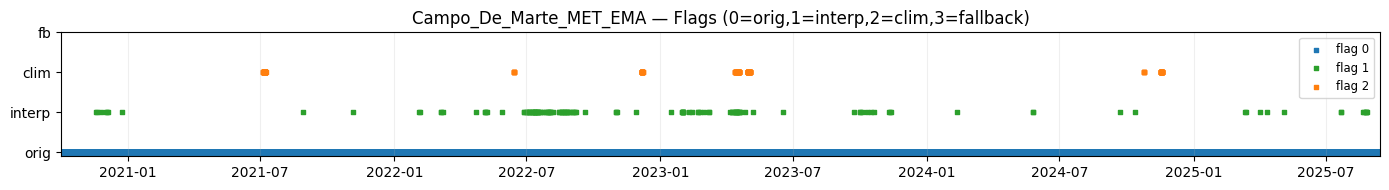

Guardado: comparativas_rellenos_vs_full_vs_original_separated\Campo_De_Marte_MET_EMA_flags_timeline.png

Todos los plots se han guardado en la carpeta: comparativas_rellenos_vs_full_vs_original_separated
Se generaron ahora PLOTS SEPARADOS para: serie completa, originales y solo rellenados.


In [16]:
#El sigueinte codigo rellena datos faltantes en combinacion segun la variable y la estacion, con los metodos de interpolacon lineal o climatologico
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
EXCEL_PATH = "senamhi_by_station.xlsx"   # ajusta si tu archivo tiene otro nombre
DATE_COL = "AÑO / MES / DÍA"
TIME_COL = "HORA"
VARIABLE = "TEMPERATURA (°C)"            # variable a rellenar y comparar
SHORT_GAP_HOURS = 3                      # huecos <= esto -> interpolación
OUT_DIR = "comparativas_rellenos_vs_full_vs_original_separated"
os.makedirs(OUT_DIR, exist_ok=True)
# ----------------------------------------

def try_parse_datetime(fecha_series, hora_series):
    """Intenta parsear combinando fecha+hora (robusto)."""
    combined = fecha_series.astype(str).str.strip() + " " + hora_series.astype(str).str.strip()
    dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)
    if dt.isna().mean() > 0.2:
        dt_alt = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt_alt.isna().mean() < dt.isna().mean():
            dt = dt_alt
    times_lower = hora_series.astype(str).str.lower()
    if dt.isna().mean() > 0.2 and times_lower.str.contains('am|pm').any():
        dt_alt2 = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt_alt2.isna().mean() < dt.isna().mean():
            dt = dt_alt2
    return dt

def choose_from_list(options, prompt):
    """Menú sencillo por número; devuelve opción o None."""
    if not options:
        return None
    while True:
        print("\n" + prompt)
        for i, o in enumerate(options, start=1):
            print(f"  {i:2d}. {o}")
        choice = input("Elige por número (o 'q' para salir): ").strip()
        if choice.lower() == 'q':
            return None
        if choice.isdigit():
            idx = int(choice)-1
            if 0 <= idx < len(options):
                return options[idx]
        print("Entrada no válida. Intenta de nuevo.")

# ---------- Leer Excel ----------
try:
    sheets = pd.read_excel(EXCEL_PATH, sheet_name=None, engine="openpyxl")
except Exception as e:
    raise SystemExit(f"Error leyendo '{EXCEL_PATH}': {e}")

sheet_names = list(sheets.keys())
if not sheet_names:
    raise SystemExit("No hay hojas/estaciones en el Excel.")

# ---------- Elegir estación ----------
station = choose_from_list(sheet_names, "Selecciona la estación (hoja) que quieres procesar:")
if station is None:
    sys.exit("Cancelado por el usuario.")

df_raw = sheets[station].copy()
df_raw.columns = df_raw.columns.str.strip()

# validar columnas necesarias
if DATE_COL not in df_raw.columns or TIME_COL not in df_raw.columns:
    raise SystemExit(f"Faltan columnas de fecha/hora ({DATE_COL}/{TIME_COL}) en la hoja seleccionada.")
if VARIABLE not in df_raw.columns:
    raise SystemExit(f"La variable {VARIABLE} no existe en la hoja seleccionada.")

# ---------- Parsear datetime y limpiar ----------
dt = try_parse_datetime(df_raw[DATE_COL], df_raw[TIME_COL])
df = df_raw.copy()
df['__dt'] = dt
n_bad_dt = int(df['__dt'].isna().sum())
if n_bad_dt > 0:
    print(f"\nAviso: {n_bad_dt} filas no pudieron parsearse como datetime y serán ignoradas.")
df = df.dropna(subset=['__dt']).set_index('__dt').sort_index()
if df.shape[0] == 0:
    raise SystemExit("No hay filas con datetime válido en la hoja seleccionada.")

# consolidar duplicados de timestamp (si existen) promediando valores numéricos
if df.index.has_duplicates:
    print("Aviso: hay timestamps duplicados; se consolidarán tomando la media numérica por timestamp.")
    df = df.groupby(df.index).mean()

# ---------- Elegir periodo ----------
while True:
    print("\nElige periodo a procesar:")
    print("  1. Total (todo el rango disponible)")
    print("  2. Un año específico (ej. 2020)")
    choice = input("Escribe 1 ó 2 (o 'q' para salir): ").strip()
    if choice.lower() == 'q':
        sys.exit("Cancelado.")
    if choice == '1':
        start = df.index.min().floor('h')
        end = df.index.max().ceil('h')
        break
    if choice == '2':
        y = input("Escribe el año (YYYY): ").strip()
        if y.lower() == 'q':
            sys.exit("Cancelado.")
        try:
            year = int(y)
        except:
            print("Año inválido. Intenta de nuevo.")
            continue
        year_start = pd.Timestamp(year=year, month=1, day=1, hour=0)
        year_end = pd.Timestamp(year=year, month=12, day=31, hour=23)
        data_min = df.index.min(); data_max = df.index.max()
        if year_end < data_min or year_start > data_max:
            print(f"No hay datos del año {year} en esta estación. Rango disponible: {data_min.date()} - {data_max.date()}.")
            continue
        start = max(year_start, data_min.floor('h'))
        end = min(year_end, data_max.ceil('h'))
        break
    print("Opción inválida. Intenta otra vez.")

full_index = pd.date_range(start=start, end=end, freq='h')
n_total_hours = len(full_index)

# ---------- Preparar series ----------
df[VARIABLE] = pd.to_numeric(df[VARIABLE], errors='coerce')
df_period = df.loc[(df.index >= start) & (df.index <= end)].copy()
series_orig = df_period[VARIABLE].reindex(full_index)  # valores con NaNs en huecos

before_present = int(series_orig.notna().sum())
before_missing = int(series_orig.isna().sum())
print(f"\nPeriodo: {start} a {end}  (horas = {n_total_hours})")
print(f"Antes del llenado: válidos={before_present}  faltantes={before_missing}")

# ---------- Llenado: interpolación y climatología ----------
# interpolación por tiempo (para huecos cortos)
series_interp = series_orig.interpolate(method='time')

# climatología horaria calculada solo con observaciones originales (no reindexadas)
orig_obs = df_period[VARIABLE].dropna()
if orig_obs.empty:
    raise SystemExit("No hay observaciones originales válidas para construir climatología.")
climatology = orig_obs.groupby(orig_obs.index.hour).mean()
overall_mean = orig_obs.mean()
climatology = climatology.reindex(range(24)).fillna(overall_mean)

# preparar estructura de filled y flags
filled = series_orig.copy()
flags = pd.Series(0, index=full_index, dtype=int)  # 0 original, 1 interp_short, 2 climatology, 3 fallback

# marcar originales
flags.loc[series_orig.notna()] = 0
flags.loc[series_orig.isna()] = 9  # marcar huecos temporalmente

# detectar bloques de NaN contiguos
is_nan = series_orig.isna()
group_id = (is_nan != is_nan.shift(1)).cumsum()
groups = series_orig.groupby(group_id)

count_interp = 0
count_clim = 0
count_fallback = 0

for gid, grp in groups:
    if not grp.isna().all():
        continue
    length = len(grp)
    idx_block = grp.index
    if length <= SHORT_GAP_HOURS:
        # rellenar por interpolación local
        filled.loc[idx_block] = series_interp.loc[idx_block]
        flags.loc[idx_block] = 1
        count_interp += length
    else:
        # rellenar con climatología horaria
        hours = idx_block.hour
        values = [climatology.get(h, overall_mean) for h in hours]
        filled.loc[idx_block] = values
        flags.loc[idx_block] = 2
        count_clim += length

# fallback si quedan NaNs
remaining_nans = filled.isna()
if remaining_nans.any():
    filled = filled.ffill().bfill()
    flags.loc[remaining_nans] = 3
    count_fallback = int(remaining_nans.sum())

after_present = int(filled.notna().sum())
after_missing = int(filled.isna().sum())

print("\nResumen de llenado:")
print(f"  Interpolación (≤ {SHORT_GAP_HOURS} h): {count_interp}")
print(f"  Climatología (largos): {count_clim}")
print(f"  Fallback ffill/bfill: {count_fallback}")
print(f"  Válidos después del llenado: {after_present}  Faltantes restantes: {after_missing}")

# ---------- Construir DataFrame resultado ----------
result_df = pd.DataFrame({
    'original': series_orig,
    'filled': filled,
    'flag': flags
}, index=full_index)

# Crear series para las tres entidades:
originals_series = result_df['original'].dropna()
filled_only_mask = result_df['flag'] != 0
filled_only_series = result_df.loc[filled_only_mask, 'filled']
full_series = result_df['filled']

# ---------- Estadísticos resumidos (imprimir) ----------
def stats_summary(serie):
    s = serie.dropna()
    return {
        'n': int(s.size),
        'mean': float(s.mean()) if s.size>0 else np.nan,
        'median': float(s.median()) if s.size>0 else np.nan,
        'std': float(s.std()) if s.size>1 else (float(0.0) if s.size==1 else np.nan),
        'min': float(s.min()) if s.size>0 else np.nan,
        'max': float(s.max()) if s.size>0 else np.nan
    }

stats_orig = stats_summary(originals_series)
stats_filled_only = stats_summary(filled_only_series)
stats_full = stats_summary(full_series)

print("\n--- ESTADÍSTICOS RESUMIDOS ---")
print("Originales (solo observados):", stats_orig)
print("Rellenados (solo los puntos imputados):", stats_filled_only)
print("Serie completa (original + rellenados):", stats_full)

# ---------- PLOTS COMPARATIVOS (hist y box) ----------

# 1) Histograma comparativo (las 3 distribuciones en un mismo eje, con transparencia)
plt.figure(figsize=(10,5))
bins = 40
if len(originals_series) > 0:
    plt.hist(originals_series, bins=bins, alpha=0.5, label=f'Originales (n={stats_orig["n"]})', density=True)
if len(filled_only_series) > 0:
    plt.hist(filled_only_series, bins=bins, alpha=0.5, label=f'Rellenados (n={stats_filled_only["n"]})', density=True)
plt.hist(full_series, bins=bins, alpha=0.3, label=f'Serie completa (n={stats_full["n"]})', density=True, color='k', histtype='stepfilled')
plt.title(f"{station} - {VARIABLE} — Histograma comparativo")
plt.xlabel(VARIABLE); plt.ylabel("Densidad (normalizada)")
plt.legend()
hist_png = os.path.join(OUT_DIR, f"{station}_comparative_hist.png")
plt.tight_layout(); plt.savefig(hist_png, dpi=150); plt.show(); plt.close()
print("Guardado:", hist_png)

# 2) Boxplots lado a lado (Originales | Rellenados | Serie completa)
box_data = [originals_series.dropna().values if len(originals_series)>0 else np.array([]),
            filled_only_series.dropna().values if len(filled_only_series)>0 else np.array([]),
            full_series.dropna().values if len(full_series)>0 else np.array([])]
labels = ['Originales', 'Rellenados', 'Serie completa']
plt.figure(figsize=(8,5))
plt.boxplot(box_data, labels=labels, showfliers=True)
plt.title(f"{station} - {VARIABLE} — Boxplots comparativos")
plt.ylabel(VARIABLE)
box_png = os.path.join(OUT_DIR, f"{station}_comparative_boxplots.png")
plt.tight_layout(); plt.savefig(box_png, dpi=150); plt.show(); plt.close()
print("Guardado:", box_png)

# ----------------- PLOTS SEPARADOS (cambio solicitado) -----------------
# En lugar de un solo plot combinando serie completa + originales + rellenados,
# generamos tres plots distintos y guardamos cada uno por separado.

# A) Plot: Serie completa (línea negra) sola
figA, axA = plt.subplots(figsize=(14,4))
axA.plot(result_df.index, result_df['filled'], color='k', linewidth=1.0, label='Serie completa (original + rellenados)')
axA.set_title(f"{station} — {VARIABLE} — Serie completa (solo línea)")
axA.set_xlabel("Fecha"); axA.set_ylabel(VARIABLE)
axA.grid(alpha=0.3)
axA.legend(loc='upper right')
pngA = os.path.join(OUT_DIR, f"{station}_series_complete_only.png")
figA.tight_layout(); figA.savefig(pngA, dpi=150); plt.show(); plt.close(figA)
print("Guardado:", pngA)

# B) Plot: Originales (puntos azules) sola
figB, axB = plt.subplots(figsize=(14,4))
mask_orig = result_df['flag'] == 0
if mask_orig.any():
    axB.scatter(result_df.index[mask_orig], result_df['original'][mask_orig], s=10, color='tab:blue', label='Originales (puntos)')
else:
    axB.text(0.5, 0.5, "No hay observaciones originales en el periodo seleccionado", ha='center', va='center')
axB.set_title(f"{station} — {VARIABLE} — Originales (solo puntos)")
axB.set_xlabel("Fecha"); axB.set_ylabel(VARIABLE)
axB.grid(alpha=0.3)
axB.legend(loc='upper right')
pngB = os.path.join(OUT_DIR, f"{station}_originals_only.png")
figB.tight_layout(); figB.savefig(pngB, dpi=150); plt.show(); plt.close(figB)
print("Guardado:", pngB)

# C) Plot: Rellenados (solo los puntos que se imputaron), coloreados por método
figC, axC = plt.subplots(figsize=(14,4))
mask_interp = result_df['flag'] == 1
mask_clim = result_df['flag'] == 2
mask_fb = result_df['flag'] == 3

plotted_any = False
if mask_interp.any():
    axC.scatter(result_df.index[mask_interp], result_df['filled'][mask_interp], s=18, color='tab:green', label='Relleno: interpolación (cortos)')
    plotted_any = True
if mask_clim.any():
    axC.scatter(result_df.index[mask_clim], result_df['filled'][mask_clim], s=18, color='tab:orange', label='Relleno: climatología (largos)')
    plotted_any = True
if mask_fb.any():
    axC.scatter(result_df.index[mask_fb], result_df['filled'][mask_fb], s=22, color='red', marker='x', label='Relleno: fallback')
    plotted_any = True

if not plotted_any:
    axC.text(0.5, 0.5, "No hay puntos rellenados en el periodo seleccionado", ha='center', va='center')

axC.set_title(f"{station} — {VARIABLE} — Puntos rellenados por método (solo rellenos)")
axC.set_xlabel("Fecha"); axC.set_ylabel(VARIABLE)
axC.grid(alpha=0.3)
axC.legend(loc='upper right')
pngC = os.path.join(OUT_DIR, f"{station}_filled_points_only.png")
figC.tight_layout(); figC.savefig(pngC, dpi=150); plt.show(); plt.close(figC)
print("Guardado:", pngC)

# 4) Tabla resumen impresa compacta (para facilitar lectura en clase)
print("\n--- TABLA RESUMEN COMPARATIVA (compacta) ---")
print(f"{'Categoria':30s} {'n':>6s} {'mean':>10s} {'median':>10s} {'std':>10s}")
print(f"{'Originales':30s} {stats_orig['n']:6d} {stats_orig['mean']:10.3f} {stats_orig['median']:10.3f} {stats_orig['std']:10.3f}")
print(f"{'Rellenados (solo imputados)':30s} {stats_filled_only['n']:6d} {stats_filled_only['mean']:10.3f} {stats_filled_only['median']:10.3f} {stats_filled_only['std']:10.3f}")
print(f"{'Serie completa (orig + rellenos)':30s} {stats_full['n']:6d} {stats_full['mean']:10.3f} {stats_full['median']:10.3f} {stats_full['std']:10.3f}")

# 5) Flags time-series (visualización pequeña)
fig5, ax5 = plt.subplots(figsize=(14,2))
flag_colors = {0:'tab:blue', 1:'tab:green', 2:'tab:orange', 3:'red'}
for fval, color in flag_colors.items():
    mask = result_df['flag'] == fval
    if mask.any():
        ax5.scatter(result_df.index[mask], [fval]*mask.sum(), marker='s', s=6, color=color, label=f"flag {fval}")
ax5.set_yticks(list(flag_colors.keys()))
ax5.set_yticklabels(['orig','interp','clim','fb'])
ax5.set_title(f"{station} — Flags (0=orig,1=interp,2=clim,3=fallback)")
ax5.set_xlim([full_index[0], full_index[-1]])
ax5.grid(axis='x', alpha=0.2)
ax5.legend(loc='upper right', fontsize='small')
png5 = os.path.join(OUT_DIR, f"{station}_flags_timeline.png")
fig5.tight_layout(); fig5.savefig(png5, dpi=150); plt.show(); plt.close(fig5)
print("Guardado:", png5)

print("\nTodos los plots se han guardado en la carpeta:", OUT_DIR)
print("Se generaron ahora PLOTS SEPARADOS para: serie completa, originales y solo rellenados.")



Selecciona la estación (hoja) que quieres procesar:
   1. Campo_De_Marte_MET_EMA
   2. Carabayllo_MET_EMA
   3. Ceres_MET_EMA
   4. Las_Palmas_MET_EMA
   5. Pantanos_De_Villa_MET_EMA
   6. San_Borja_MET_EMA
   7. San_Martin_De_Porres_MET_EAA

Variables detectadas (y #valores numéricos):
   1. DIRECCION DEL VIENTO (°)  (num válidos = 39111)
   2. HUMEDAD (%)  (num válidos = 39108)
   3. VELOCIDAD DEL VIENTO (m/s)  (num válidos = 39108)
   4. TEMPERATURA (°C)  (num válidos = 39033)

Variable elegida: TEMPERATURA (°C)
Valores numéricos válidos detectados para 'TEMPERATURA (°C)': 39033

Rango de años disponibles en la estación: 2020 - 2025
  0. Todo el rango (total)
  2020   2021   2022   2023   2024   2025 

--- RESUMEN ---
Estación: Carabayllo_MET_EMA
Variable: TEMPERATURA (°C)
Modo: target = año 2020 (solo huecos dentro de este año fueron rellenados).
Rango full: 2020-09-01 00:00:00 -> 2025-09-13 12:00:00
Rango objetivo: 2020-09-01 00:00:00 -> 2020-12-31 23:00:00 (horas = 2928)
Observa

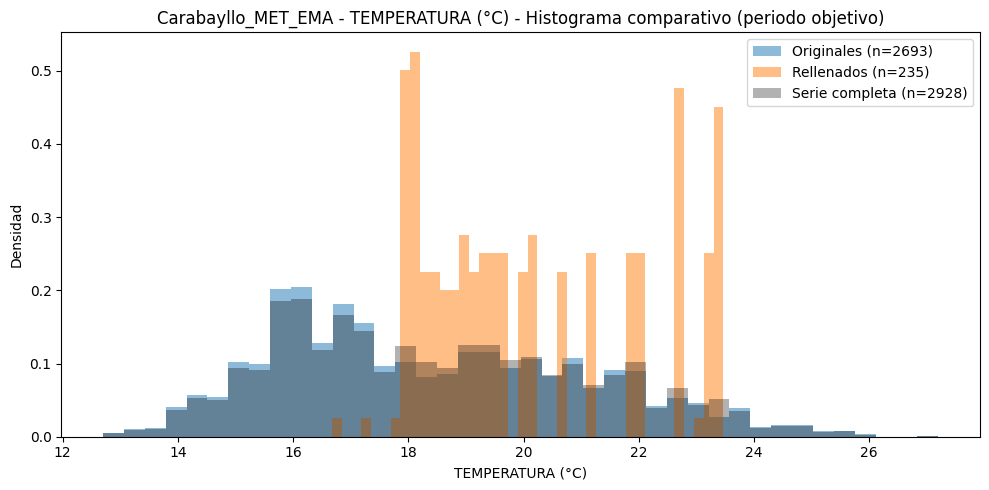

C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\2963865354.py:318: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels, showfliers=True)


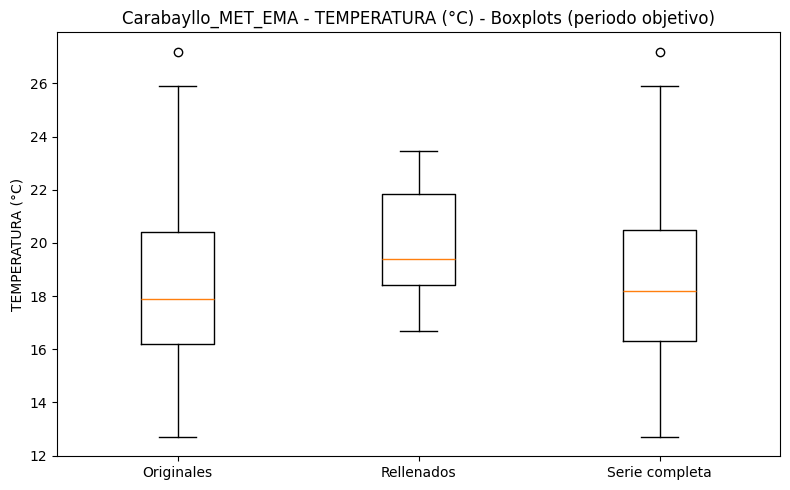

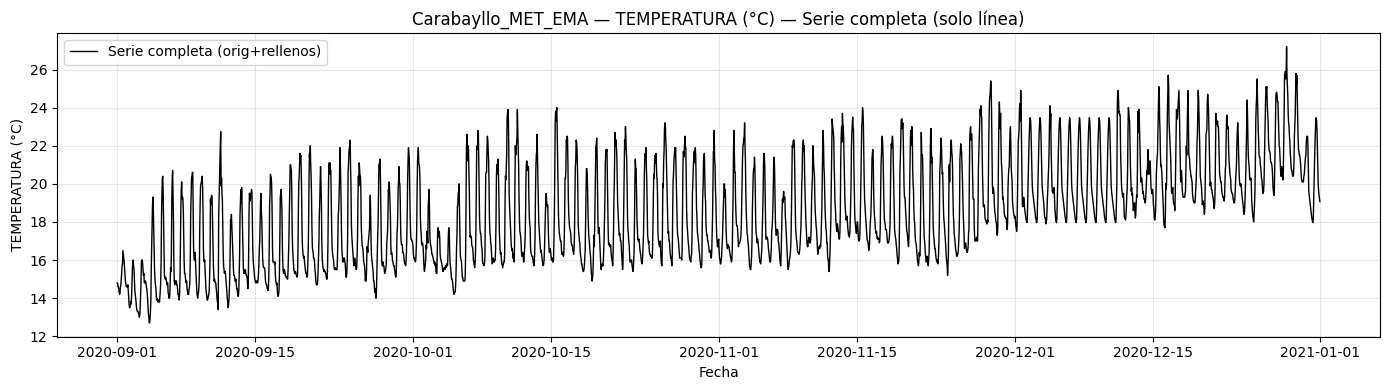

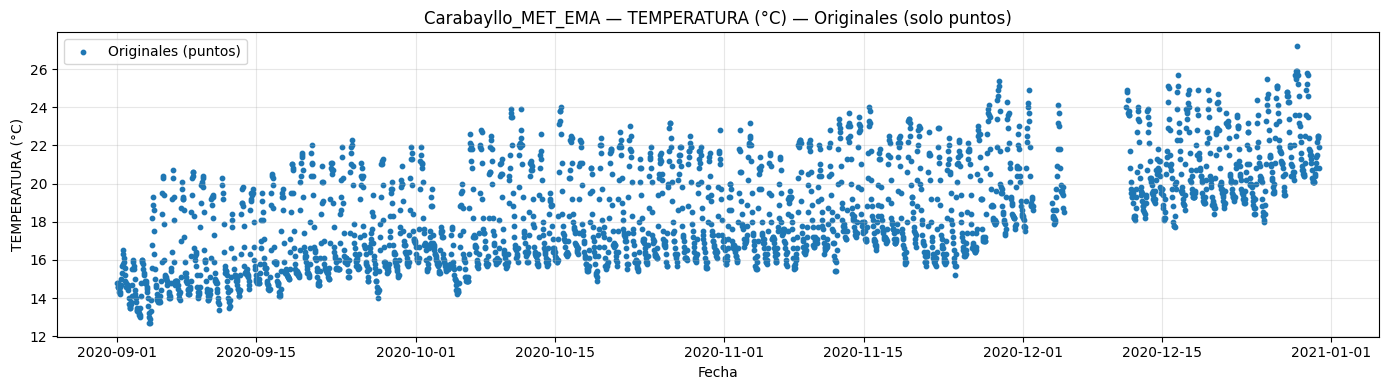

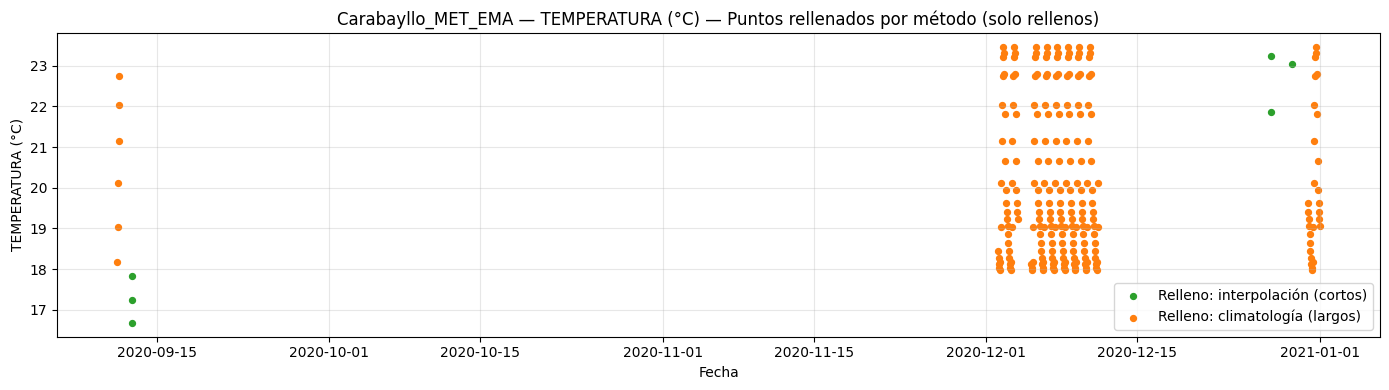

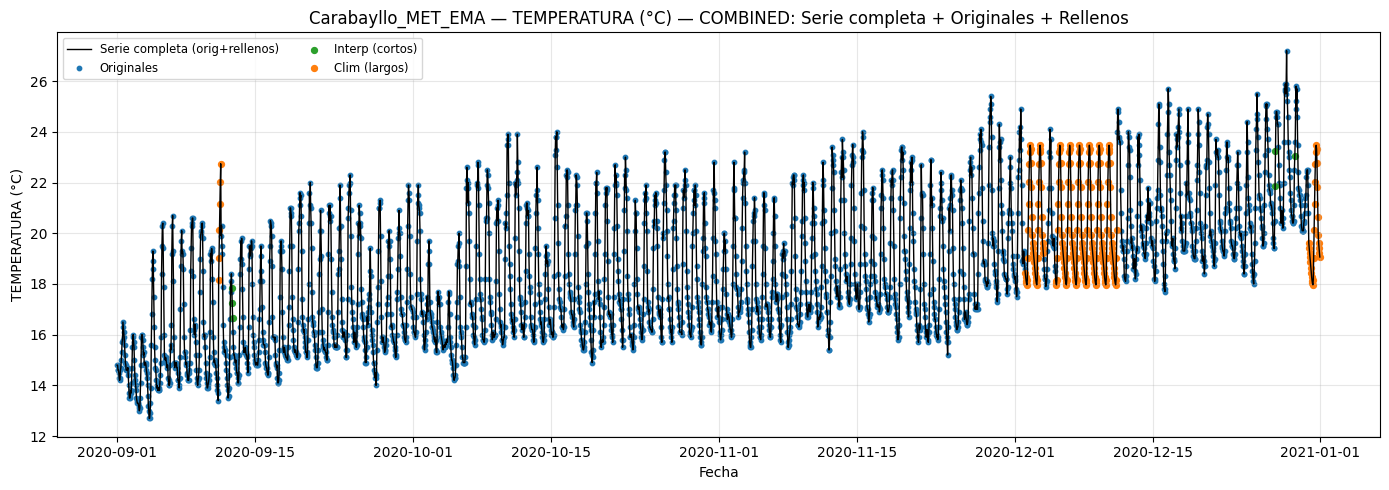

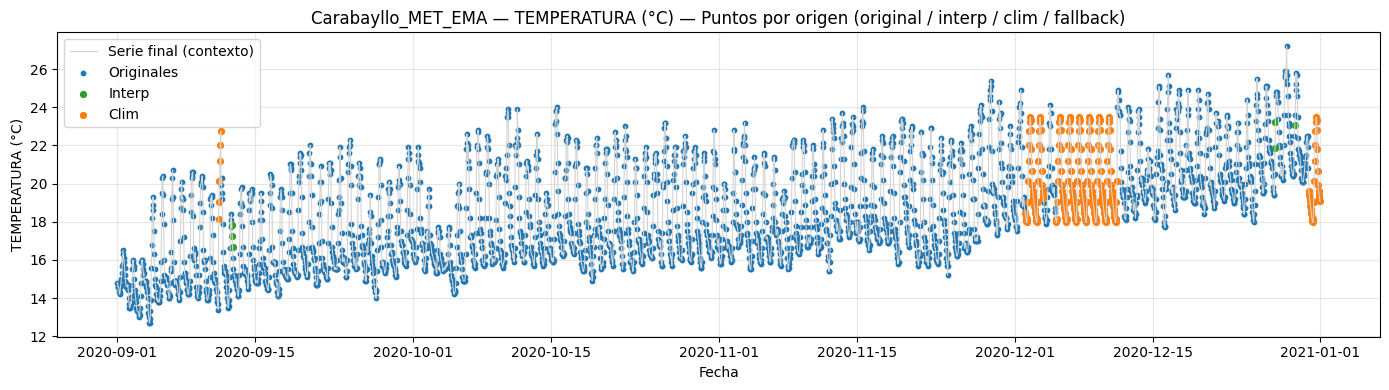

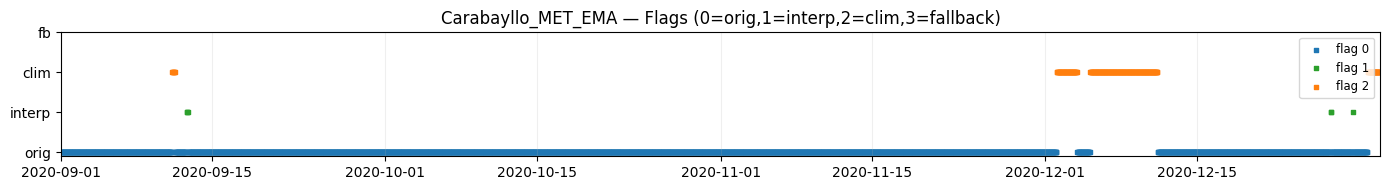


--- RESUMEN TABLA COMPACTA (periodo objetivo) ---
Categoria                               n       mean     median        std
Originales                           2693     18.366     17.900      2.701
Rellenados (solo imputados en objetivo)    235     20.138     19.410      1.885
Serie completa (orig + rellenos) en objetivo   2928     18.508     18.200      2.688

Terminado. (plots mostrados en pantalla; CSV guardado en carpeta de salida).


In [18]:
# -*- coding: utf-8 -*-
"""
Pipeline completo (fix mínimo):
 - corrige ValueError en flags timeline
 - muestra plots con plt.show() (no guarda ni imprime mensajes de guardado)
 - mantiene resto de la lógica igual
"""

import os
import sys
import re
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
EXCEL_PATH = "senamhi_by_station.xlsx"
DATE_COL = "AÑO / MES / DÍA"
TIME_COL = "HORA"
OUT_DIR = "fills_full_plots_all_fixed_minimal_showplots"
SHORT_GAP_HOURS = 3
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- util: safe filename (se usa para CSV) ----------
def safe_name(s, maxlen=120):
    if s is None:
        return ""
    s_norm = unicodedata.normalize('NFKD', str(s))
    s_ascii = s_norm.encode('ascii', 'ignore').decode('ascii')
    s_clean = re.sub(r'[^0-9A-Za-z\-\._]+', '_', s_ascii)
    s_clean = re.sub(r'_+', '_', s_clean).strip('_')
    if len(s_clean) > maxlen:
        s_clean = s_clean[:maxlen].rstrip('_')
    return s_clean

def ensure_dir(path):
    try:
        os.makedirs(path, exist_ok=True)
    except Exception as e:
        raise OSError(f"No se pudo crear directorio '{path}': {e}")

def safe_to_csv(df, path):
    """Guardar DataFrame en CSV sin imprimir mensajes (silencioso)."""
    try:
        parent = os.path.dirname(path)
        if parent and not os.path.isdir(parent):
            ensure_dir(parent)
        df.to_csv(path, index_label='datetime')
    except Exception as e:
        print("ERROR guardando CSV en", path, "->", e)

# ---------- helper: parse datetime ----------
def try_parse_datetime(fecha_series, hora_series):
    combined = fecha_series.astype(str).str.strip() + " " + hora_series.astype(str).str.strip()
    dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)
    if dt.isna().mean() > 0.2:
        dt_alt = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt_alt.isna().mean() < dt.isna().mean():
            dt = dt_alt
    times_lower = hora_series.astype(str).str.lower()
    if dt.isna().mean() > 0.2 and times_lower.str.contains('am|pm').any():
        dt2 = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt2.isna().mean() < dt.isna().mean():
            dt = dt2
    return dt

def choose_from_list(options, prompt):
    if not options:
        return None
    while True:
        print("\n" + prompt)
        for i, o in enumerate(options, 1):
            print(f"  {i:2d}. {o}")
        sel = input("Elige por número (o 'q' para salir): ").strip()
        if sel.lower() == 'q':
            return None
        if sel.isdigit():
            idx = int(sel) - 1
            if 0 <= idx < len(options):
                return options[idx]
        print("Entrada inválida. Intenta de nuevo.")

# ---------------- MAIN ----------------
def main():
    # leer excel
    try:
        sheets = pd.read_excel(EXCEL_PATH, sheet_name=None, engine="openpyxl")
    except Exception as e:
        raise SystemExit(f"Error leyendo '{EXCEL_PATH}': {e}")

    sheet_names = list(sheets.keys())
    if not sheet_names:
        raise SystemExit("No hay hojas/estaciones en el Excel.")

    station = choose_from_list(sheet_names, "Selecciona la estación (hoja) que quieres procesar:")
    if station is None:
        sys.exit("Cancelado por el usuario.")

    df_raw = sheets[station].copy()
    df_raw.columns = df_raw.columns.str.strip()

    if DATE_COL not in df_raw.columns or TIME_COL not in df_raw.columns:
        raise SystemExit(f"Faltan columnas de fecha/hora ({DATE_COL}/{TIME_COL}) en la hoja seleccionada.")

    candidates = [c for c in df_raw.columns if c not in (DATE_COL, TIME_COL)]
    cand_with_count = [(c, int(pd.to_numeric(df_raw[c], errors='coerce').notna().sum())) for c in candidates]
    cand_with_count_sorted = sorted(cand_with_count, key=lambda x: x[1], reverse=True)

    print("\nVariables detectadas (y #valores numéricos):")
    for i, (c, n) in enumerate(cand_with_count_sorted, 1):
        print(f"  {i:2d}. {c}  (num válidos = {n})")
    sel = input("Selecciona variable por número (Enter = primera) or 'q' para salir: ").strip()
    if sel.lower() == 'q':
        sys.exit("Cancelado.")
    if sel == "":
        var = cand_with_count_sorted[0][0]
    else:
        if not sel.isdigit() or int(sel)-1 not in range(len(cand_with_count_sorted)):
            print("Selección inválida; se usará la primera variable.")
            var = cand_with_count_sorted[0][0]
        else:
            var = cand_with_count_sorted[int(sel)-1][0]
    print(f"\nVariable elegida: {var}")

    # parse datetime
    dt = try_parse_datetime(df_raw[DATE_COL], df_raw[TIME_COL])
    df = df_raw.copy()
    df['__dt'] = dt
    n_bad = int(df['__dt'].isna().sum())
    if n_bad > 0:
        print(f"Advertencia: {n_bad} filas no pudieron parsearse como datetime y se ignorarán.")
    df = df.dropna(subset=['__dt']).set_index('__dt').sort_index()
    if df.index.has_duplicates:
        print("Aviso: timestamps duplicados; se consolidarán (media numérica).")
        df = df.groupby(df.index).mean()

    # convertir variable a numérica
    df[var] = pd.to_numeric(df[var], errors='coerce')
    n_valid_after_conv = int(df[var].notna().sum())
    if n_valid_after_conv == 0:
        raise SystemExit(f"La variable '{var}' no tiene valores numéricos después de convertir; no se puede continuar.")
    print(f"Valores numéricos válidos detectados para '{var}': {n_valid_after_conv}")

    # elegir periodo
    min_year = df.index.min().year
    max_year = df.index.max().year
    print(f"\nRango de años disponibles en la estación: {min_year} - {max_year}")
    print("  0. Todo el rango (total)")
    for y in range(min_year, max_year+1):
        print(f"  {y} ", end="")
    print()
    year_sel = input("Introduce un AÑO para procesar (ej. 2022) o 0 para 'total': ").strip()
    if year_sel == "" or year_sel == "0":
        mode = 'total'
    else:
        try:
            ysel = int(year_sel)
            if not (min_year <= ysel <= max_year):
                print("Año fuera de rango. Se usará 'total'.")
                mode = 'total'
            else:
                mode = 'year'
                year = ysel
        except:
            print("Entrada no válida. Se usará 'total'.")
            mode = 'total'

    # indices completos
    full_start = df.index.min().floor('h')
    full_end = df.index.max().ceil('h')
    full_index = pd.date_range(start=full_start, end=full_end, freq='h')
    series_full = df[var].reindex(full_index)

    # interpolación y climatología
    series_interp_full = series_full.interpolate(method='time')
    orig_observations = df[var].dropna()
    if orig_observations.empty:
        raise SystemExit("No hay observaciones originales válidas para calcular climatología.")
    try:
        climatology = orig_observations.groupby(orig_observations.index.hour).mean()
    except Exception:
        cl = {}
        for h in range(24):
            vals = orig_observations[orig_observations.index.hour == h]
            cl[h] = vals.mean() if len(vals) > 0 else np.nan
        climatology = pd.Series(cl)
    overall_mean = orig_observations.mean()
    climatology = climatology.reindex(range(24)).fillna(overall_mean)

    # target period
    if mode == 'total':
        target_start, target_end = full_start, full_end
    else:
        target_start = pd.Timestamp(year=year, month=1, day=1, hour=0)
        target_end = pd.Timestamp(year=year, month=12, day=31, hour=23)
        if target_end < full_start or target_start > full_end:
            raise SystemExit(f"No hay datos en el año {year} en esta estación.")
        target_start = max(target_start, full_start)
        target_end = min(target_end, full_end)
    target_index = pd.date_range(start=target_start, end=target_end, freq='h')

    # prepare filled and flags
    filled_full = series_full.copy()
    flags = pd.Series(-1, index=full_index, dtype=int)  # -1 fuera objetivo, 0 original, 1 interp, 2 clim, 3 fallback
    flags[series_full.notna()] = 0

    # detectar bloques NaN y rellenar solo los que intersectan target
    is_nan_full = filled_full.isna()
    group_id = (is_nan_full != is_nan_full.shift(1)).cumsum()
    groups = filled_full.groupby(group_id)

    count_interp = count_clim = count_fallback = 0

    for gid, grp in groups:
        if not grp.isna().all():
            continue
        grp_idx = grp.index
        inter = grp_idx[(grp_idx >= target_start) & (grp_idx <= target_end)]
        if len(inter) == 0:
            continue
        length_block = len(grp_idx)
        if length_block <= SHORT_GAP_HOURS:
            vals = series_interp_full.loc[inter]
            filled_full.loc[inter] = vals
            flags.loc[inter] = 1
            count_interp += len(inter)
        else:
            hours = inter.hour
            vals = [climatology.get(h, overall_mean) for h in hours]
            filled_full.loc[inter] = vals
            flags.loc[inter] = 2
            count_clim += len(inter)

    # fallback ffill/bfill dentro del target
    still_nan_positions = filled_full[target_start:target_end].isna()
    if still_nan_positions.any():
        temp = filled_full.copy().ffill().bfill()
        pos_to_fill = temp[target_start:target_end].index[still_nan_positions]
        if len(pos_to_fill) > 0:
            filled_full.loc[pos_to_fill] = temp.loc[pos_to_fill]
            flags.loc[pos_to_fill] = 3
            count_fallback += len(pos_to_fill)

    # resumen
    n_original = int(series_full.notna().sum())
    n_filled_in_target = int(((flags != 0) & (flags != -1) & (flags.index >= target_start) & (flags.index <= target_end)).sum())
    n_total_target_slots = len(target_index)
    n_missing_after = int(filled_full[target_start:target_end].isna().sum())

    print("\n--- RESUMEN ---")
    print(f"Estación: {station}")
    print(f"Variable: {var}")
    if mode == 'total':
        print("Modo: target = TODO el rango disponible.")
    else:
        print(f"Modo: target = año {year} (solo huecos dentro de este año fueron rellenados).")
    print(f"Rango full: {full_start} -> {full_end}")
    print(f"Rango objetivo: {target_start} -> {target_end} (horas = {n_total_target_slots})")
    print(f"Observaciones originales: {n_original}")
    print(f"Puntos rellenados: {n_filled_in_target} (interp={count_interp}, clim={count_clim}, fallback={count_fallback})")
    print(f"Faltantes restantes: {n_missing_after}")

    # preparar series para comparativas
    originals_target = series_full[target_start:target_end].dropna()
    filled_mask_target = (flags[target_start:target_end] != 0) & (flags[target_start:target_end] != -1)
    filled_only_target = filled_full[target_start:target_end].loc[filled_mask_target]
    full_target_series = filled_full[target_start:target_end]

    def summary_stats(s):
        s2 = s.dropna()
        return {
            'n': int(s2.size),
            'mean': float(s2.mean()) if s2.size>0 else np.nan,
            'median': float(s2.median()) if s2.size>0 else np.nan,
            'std': float(s2.std()) if s2.size>1 else (0.0 if s2.size==1 else np.nan)
        }

    stats_orig = summary_stats(originals_target)
    stats_filled = summary_stats(filled_only_target)
    stats_full_target = summary_stats(full_target_series)

    print("\n--- Estadísticos (en el periodo objetivo) ---")
    print("Originales (solo observados):", stats_orig)
    print("Rellenados (solo imputados):", stats_filled)
    print("Serie final (orig + rellenos):", stats_full_target)

    # preparar carpeta salida para CSV
    safe_station = safe_name(station)
    safe_var = safe_name(var)
    outdir_var = os.path.join(OUT_DIR, safe_station, safe_var)
    ensure_dir(outdir_var)

    # ---------------- PLOTS (MOSTRAR con plt.show) ----------------

    # Histograma comparativo
    plt.figure(figsize=(10,5))
    bins = 40
    if stats_orig['n']>0:
        plt.hist(originals_target, bins=bins, alpha=0.5, label=f'Originales (n={stats_orig["n"]})', density=True)
    if stats_filled['n']>0:
        plt.hist(filled_only_target, bins=bins, alpha=0.5, label=f'Rellenados (n={stats_filled["n"]})', density=True)
    plt.hist(full_target_series, bins=bins, alpha=0.3, label=f'Serie completa (n={stats_full_target["n"]})', density=True, color='k', histtype='stepfilled')
    plt.title(f"{station} - {var} - Histograma comparativo (periodo objetivo)")
    plt.xlabel(var); plt.ylabel("Densidad"); plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

    # Boxplots comparativos
    box_data = [
        originals_target.dropna().values if stats_orig['n']>0 else np.array([]),
        filled_only_target.dropna().values if stats_filled['n']>0 else np.array([]),
        full_target_series.dropna().values if stats_full_target['n']>0 else np.array([])
    ]
    labels = ['Originales', 'Rellenados', 'Serie completa']
    plt.figure(figsize=(8,5))
    plt.boxplot(box_data, labels=labels, showfliers=True)
    plt.title(f"{station} - {var} - Boxplots (periodo objetivo)")
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()
    plt.close()

    # Serie completa (línea)
    figA, axA = plt.subplots(figsize=(14,4))
    axA.plot(full_target_series.index, full_target_series.values, color='k', linewidth=1.0, label='Serie completa (orig+rellenos)')
    axA.set_title(f"{station} — {var} — Serie completa (solo línea)")
    axA.set_xlabel("Fecha"); axA.set_ylabel(var); axA.grid(alpha=0.3); axA.legend()
    plt.tight_layout(); plt.show(); plt.close(figA)

    # Originales (puntos) - CORREGIDO (usa originals_target directamente)
    figB, axB = plt.subplots(figsize=(14,4))
    if len(originals_target) > 0:
        axB.scatter(originals_target.index, originals_target.values, s=10, color='tab:blue', label='Originales (puntos)')
    else:
        axB.text(0.5, 0.5, "No hay observaciones originales en el periodo seleccionado", ha='center', va='center')
    axB.set_title(f"{station} — {var} — Originales (solo puntos)")
    axB.set_xlabel("Fecha"); axB.set_ylabel(var); axB.grid(alpha=0.3)
    axB.legend()
    plt.tight_layout(); plt.show(); plt.close(figB)

    # Rellenados (solo puntos)
    figC, axC = plt.subplots(figsize=(14,4))
    mask_interp = flags[target_start:target_end] == 1
    mask_clim = flags[target_start:target_end] == 2
    mask_fb   = flags[target_start:target_end] == 3
    plotted = False
    if mask_interp.any():
        axC.scatter(filled_full[target_start:target_end].index[mask_interp], filled_full[target_start:target_end][mask_interp], s=18, color='tab:green', label='Relleno: interpolación (cortos)')
        plotted = True
    if mask_clim.any():
        axC.scatter(filled_full[target_start:target_end].index[mask_clim], filled_full[target_start:target_end][mask_clim], s=18, color='tab:orange', label='Relleno: climatología (largos)')
        plotted = True
    if mask_fb.any():
        axC.scatter(filled_full[target_start:target_end].index[mask_fb], filled_full[target_start:target_end][mask_fb], s=22, color='red', marker='x', label='Relleno: fallback')
        plotted = True
    if not plotted:
        axC.text(0.5, 0.5, "No hay puntos rellenados en el periodo seleccionado", ha='center')
    axC.set_title(f"{station} — {var} — Puntos rellenados por método (solo rellenos)")
    axC.set_xlabel("Fecha"); axC.set_ylabel(var); axC.grid(alpha=0.3); axC.legend()
    plt.tight_layout(); plt.show(); plt.close(figC)

    # COMBINED plot: serie completa + originales + rellenados
    figD, axD = plt.subplots(figsize=(14,5))
    axD.plot(full_target_series.index, full_target_series.values, color='k', linewidth=1.0, label='Serie completa (orig+rellenos)')
    if len(originals_target) > 0:
        axD.scatter(originals_target.index, originals_target.values, s=10, color='tab:blue', label='Originales')
    if mask_interp.any():
        axD.scatter(filled_full[target_start:target_end].index[mask_interp], filled_full[target_start:target_end][mask_interp], s=18, color='tab:green', label='Interp (cortos)')
    if mask_clim.any():
        axD.scatter(filled_full[target_start:target_end].index[mask_clim], filled_full[target_start:target_end][mask_clim], s=18, color='tab:orange', label='Clim (largos)')
    if mask_fb.any():
        axD.scatter(filled_full[target_start:target_end].index[mask_fb], filled_full[target_start:target_end][mask_fb], s=22, color='red', marker='x', label='Fallback')
    axD.set_title(f"{station} — {var} — COMBINED: Serie completa + Originales + Rellenos")
    axD.set_xlabel("Fecha"); axD.set_ylabel(var); axD.grid(alpha=0.3); axD.legend(ncol=2, fontsize='small')
    plt.tight_layout(); plt.show(); plt.close(figD)

    # Colored-by-origin plot
    figE, axE = plt.subplots(figsize=(14,4))
    axE.plot(full_target_series.index, full_target_series.values, color='lightgray', linewidth=0.8, label='Serie final (contexto)')
    if len(originals_target)>0:
        axE.scatter(originals_target.index, originals_target.values, s=10, color='tab:blue', label='Originales')
    if mask_interp.any():
        axE.scatter(filled_full[target_start:target_end].index[mask_interp], filled_full[target_start:target_end][mask_interp], s=18, color='tab:green', label='Interp')
    if mask_clim.any():
        axE.scatter(filled_full[target_start:target_end].index[mask_clim], filled_full[target_start:target_end][mask_clim], s=18, color='tab:orange', label='Clim')
    if mask_fb.any():
        axE.scatter(filled_full[target_start:target_end].index[mask_fb], filled_full[target_start:target_end][mask_fb], s=22, color='red', marker='x', label='Fallback')
    axE.set_title(f"{station} — {var} — Puntos por origen (original / interp / clim / fallback)")
    axE.set_xlabel("Fecha"); axE.set_ylabel(var); axE.grid(alpha=0.3); axE.legend()
    plt.tight_layout(); plt.show(); plt.close(figE)

    # Flags timeline (FIX: usar índices alineados)
    figF, axF = plt.subplots(figsize=(14,2))
    flag_colors = {0:'tab:blue', 1:'tab:green', 2:'tab:orange', 3:'red'}
    seg = flags[target_start:target_end]  # serie ya recortada y alineada
    for fval, color in flag_colors.items():
        idx = seg[seg == fval].index
        if len(idx) > 0:
            y = np.full(len(idx), fval)
            axF.scatter(idx, y, marker='s', s=6, color=color, label=f"flag {fval}")
    axF.set_yticks(list(flag_colors.keys()))
    axF.set_yticklabels(['orig','interp','clim','fb'])
    axF.set_title(f"{station} — Flags (0=orig,1=interp,2=clim,3=fallback)")
    axF.set_xlim([target_start, target_end])
    axF.grid(axis='x', alpha=0.2)
    axF.legend(loc='upper right', fontsize='small')
    plt.tight_layout(); plt.show(); plt.close(figF)

    # Tabla resumen impresa
    print("\n--- RESUMEN TABLA COMPACTA (periodo objetivo) ---")
    print(f"{'Categoria':34s} {'n':>6s} {'mean':>10s} {'median':>10s} {'std':>10s}")
    print(f"{'Originales':34s} {stats_orig['n']:6d} {stats_orig['mean']:10.3f} {stats_orig['median']:10.3f} {stats_orig['std']:10.3f}")
    print(f"{'Rellenados (solo imputados en objetivo)':34s} {stats_filled['n']:6d} {stats_filled['mean']:10.3f} {stats_filled['median']:10.3f} {stats_filled['std']:10.3f}")
    print(f"{'Serie completa (orig + rellenos) en objetivo':34s} {stats_full_target['n']:6d} {stats_full_target['mean']:10.3f} {stats_full_target['median']:10.3f} {stats_full_target['std']:10.3f}")

    # Guardar CSV (silencioso)
    out_csv = os.path.join(outdir_var, f"{safe_station}__{safe_var}_filled_target_{target_start.date()}_{target_end.date()}.csv")
    out_df = pd.DataFrame({'original': series_full, 'filled_full': filled_full, 'flag': flags})
    safe_to_csv(out_df, out_csv)

    print("\nTerminado. (plots mostrados en pantalla; CSV guardado en carpeta de salida).")

if __name__ == "__main__":
    main()



Selecciona la estación (hoja) a procesar:
   1. Campo Marte
   2. San Borja

Selecciona el contaminante a procesar:
   1. PM 2.5
   2. PM 10
   3. SO 2
   4. NO 2
   5. O 3
   6. CO
Periodo detectado en la hoja: 2024-08-26 00:00:00 -> 2024-10-27 00:00:00  (~63 días, ~2.1 meses)

Elige el periodo a analizar:
  1. Todo el periodo disponible
  2. Un año específico (del periodo disponible)


C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\993393452.py:39: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)
C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\993393452.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dt = pd.to_datetime(dt, errors='coerce').dt.floor('H')
C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\993393452.py:209: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  target_start = df.index.min().floor('H')
C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\993393452.py:210: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  target_end = df.index.max().ceil('H')
C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\993393452.py:247


--- Resumen conteo ---
Estacion: Campo Marte
Contaminante: PM 2.5
Periodo: TODO el rango disponible
Horas en periodo objetivo: 1489
Observaciones originales (no-NaN): 1485
Faltantes (NaN): 4
QC flags en periodo objetivo -> OK: 1311, Sospechoso: 178, Fail: 0
Puntos rellenados dentro del objetivo: 4

Estadísticos (periodo objetivo):
Originales: {'n': 1485, 'mean': 24.258215488215487, 'median': 22.5, 'std': 10.15863789933011}
Rellenados (solo imputados): {'n': 4, 'mean': 31.71125, 'median': 33.5875, 'std': 13.032325435239867}
Serie final (orig + rellenos): {'n': 1489, 'mean': 24.278237071860307, 'median': 22.5, 'std': 10.169161877519967}


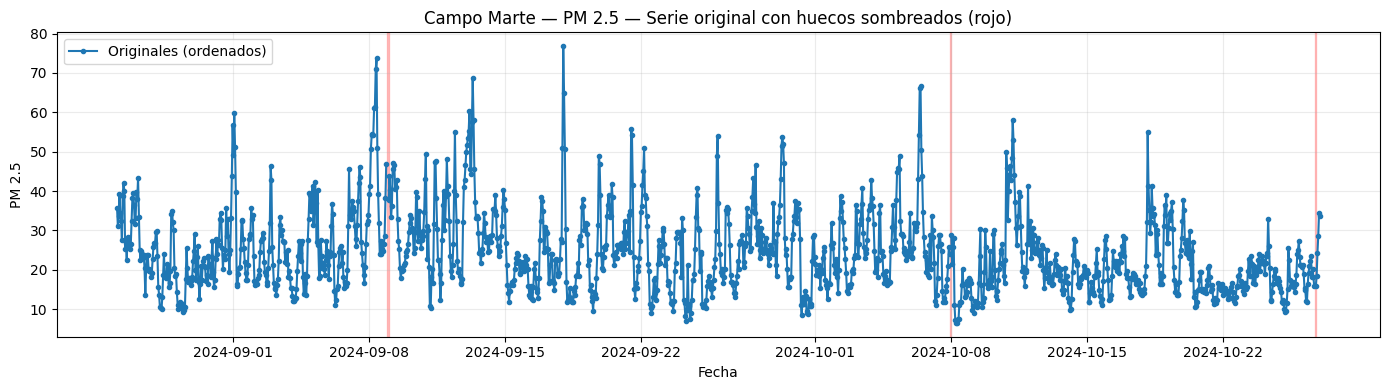

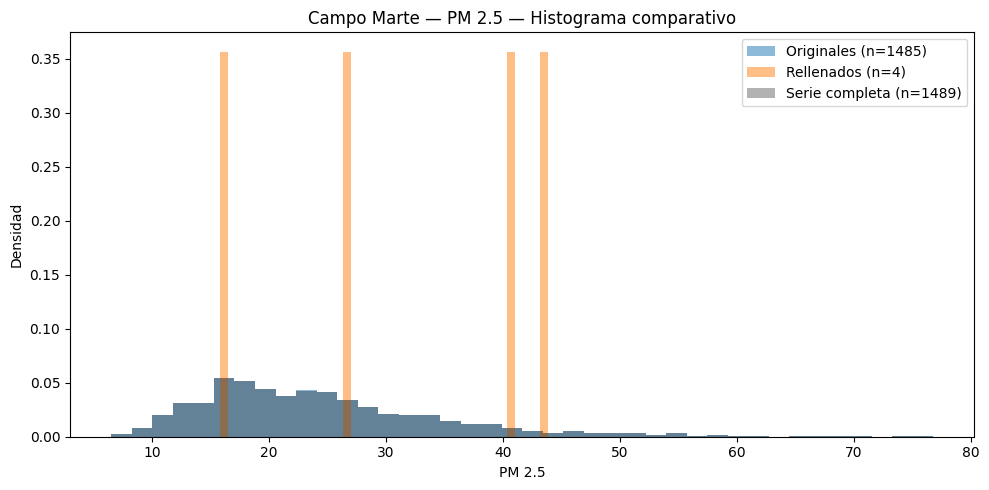

C:\Users\Mariano\AppData\Local\Temp\ipykernel_17396\993393452.py:362: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=['Originales','Rellenados','Serie completa'], showfliers=True)


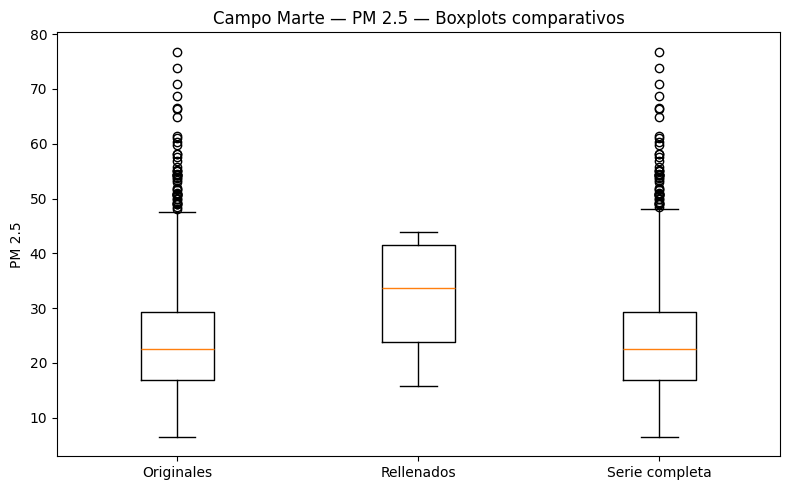

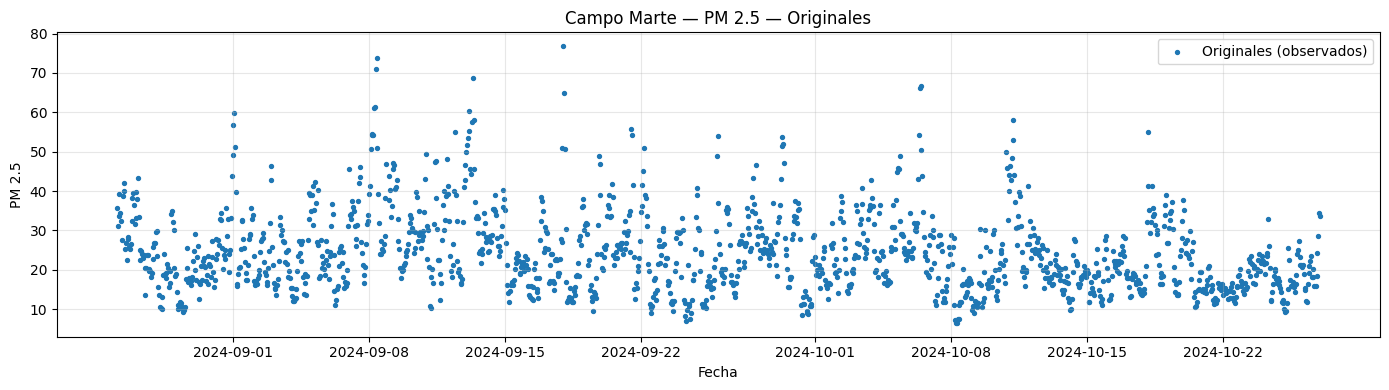

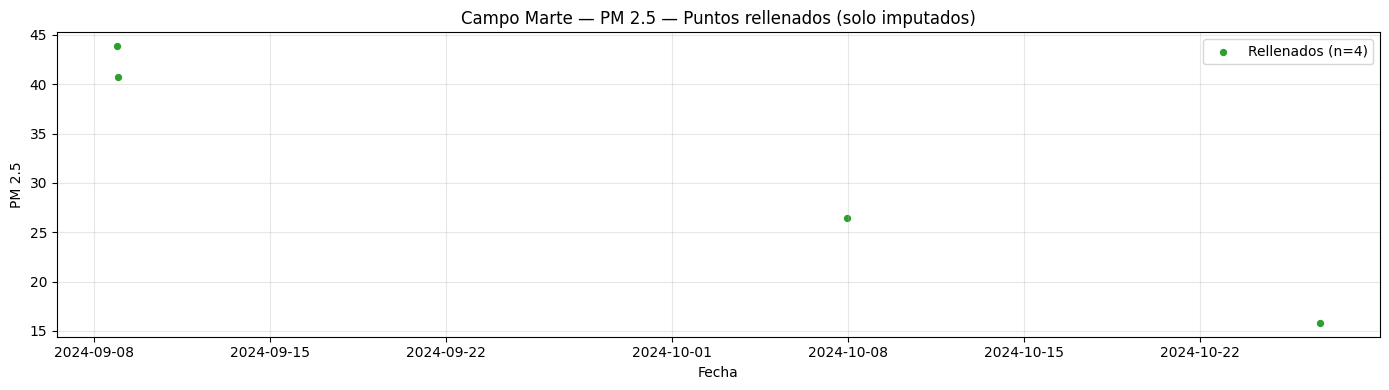

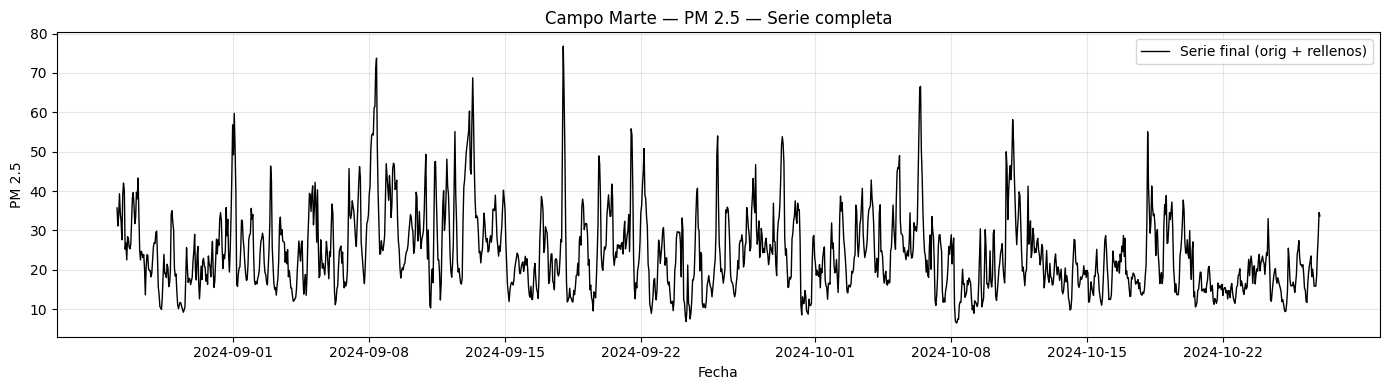

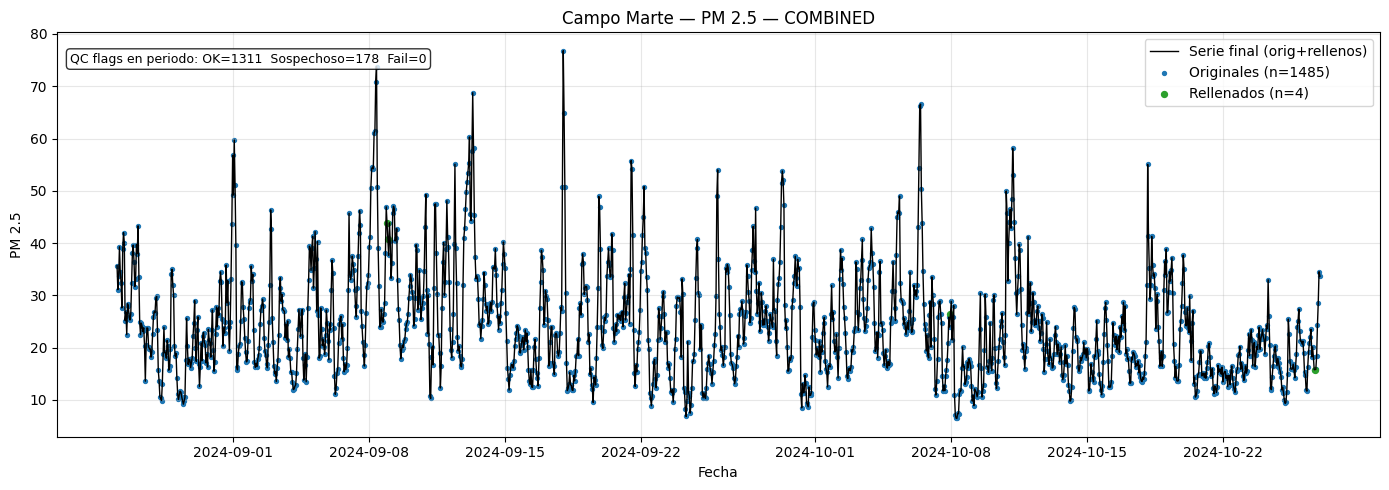

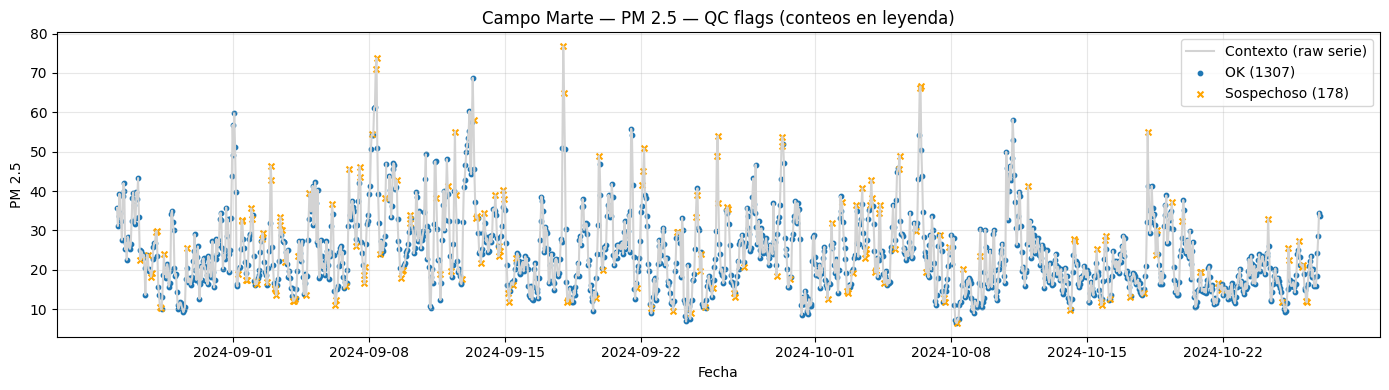


Proceso terminado. Gráficos mostrados en pantalla. CSV (silencioso) guardado en: outputs_contaminantes\Campo_Marte__PM_2_5__filled_2024-08-26_2024-10-27.csv


In [ ]:
# -*- coding: utf-8 -*-
"""
Pipeline contaminantes — con plot extra: serie original + sombreado rojo en huecos.
Mantiene selección de periodo (todo / año -> mes), QC, interpolación sobre serie completa,
relleno solo en periodo objetivo, comparativas y plots mostrados con plt.show().
"""

import os, sys, re, unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# ------- CONFIG -------
EXCEL_PATH = "Datos_Contaminación.xlsx"   # ajusta si hace falta
DATE_COL = "Fecha"
TIME_COL = "Hora"
POLLUTANT_COLS = ["PM 2.5", "PM 10", "SO 2", "NO 2", "O 3", "CO"]
SHORT_GAP_HOURS = 3   # umbral para considerar huecos 'cortos'
RANGES = {
    "PM_2_5": (0.0, 2000.0),
    "PM_10": (0.0, 2000.0),
    "SO_2": (0.0, 2000.0),
    "NO_2": (0.0, 2000.0),
    "O_3": (0.0, 2000.0),
    "CO": (0.0, 50.0),
}
OUT_DIR = "outputs_contaminantes"
os.makedirs(OUT_DIR, exist_ok=True)
# ----------------------

def normalize_colname(c):
    nc = re.sub(r"[\s\.]+", "_", str(c)).strip("_")
    nc = re.sub(r"__+", "_", nc)
    return nc

def try_parse_datetime(fecha_series, hora_series):
    combined = fecha_series.astype(str).str.strip() + " " + hora_series.astype(str).str.strip()
    dt = pd.to_datetime(combined, errors='coerce', dayfirst=True)
    if dt.isna().mean() > 0.1:
        dt2 = pd.to_datetime(combined, errors='coerce', dayfirst=False)
        if dt2.isna().mean() < dt.isna().mean():
            dt = dt2
    # fallback simple para horas en 12h/24h/enteras
    try:
        if dt.isna().any() and np.issubdtype(fecha_series.dtype, np.datetime64):
            h_parsed = pd.to_datetime(hora_series.astype(str).str.replace(" ", ""), format="%I:%M%p", errors='coerce')
            if h_parsed.notna().any():
                base = fecha_series.dt.normalize()
                hrs = h_parsed.dt.hour.fillna(0).astype(int)
                mins = h_parsed.dt.minute.fillna(0).astype(int)
                alt = base + pd.to_timedelta(hrs, unit='h') + pd.to_timedelta(mins, unit='m')
                dt = dt.fillna(alt)
    except Exception:
        pass
    try:
        dt = pd.to_datetime(dt, errors='coerce').dt.floor('H')
    except Exception:
        dt = pd.to_datetime(dt, errors='coerce')
    return dt

# QC helpers
def flag_range(series, lo, hi):
    f = pd.Series(0, index=series.index)
    try:
        mask = series.notna() & ((series < lo) | (series > hi))
        f[mask] = 2
    except Exception:
        pass
    return f

def hampel_flag(series, window=7, n_sigmas=4):
    s = series.copy()
    roll_med = s.rolling(window=window, center=True, min_periods=1).median()
    mad = (s - roll_med).abs().rolling(window=window, center=True, min_periods=1).median()
    threshold = n_sigmas * 1.4826 * mad
    flag = pd.Series(0, index=s.index)
    flag[(s - roll_med).abs() > threshold] = 1
    return flag

def persistence_flag(series, n_periods=24):
    v = series.copy()
    same = v == v.shift(1)
    run_id = (~same).cumsum()
    run_len = same.groupby(run_id).cumcount() + 1
    flag = pd.Series(0, index=series.index)
    flag[run_len >= n_periods] = 2
    return flag

def combine_flags(*flags):
    if len(flags) == 0:
        return pd.Series(dtype=int)
    fstack = pd.concat(flags, axis=1)
    out = pd.Series(0, index=fstack.index)
    out[(fstack == 2).any(axis=1)] = 2
    out[((fstack == 1).any(axis=1)) & (out != 2)] = 1
    return out

def choose_from_list(options, prompt):
    if not options:
        return None
    while True:
        print("\n" + prompt)
        for i, o in enumerate(options, 1):
            print(f"  {i:2d}. {o}")
        sel = input("Elige por número (o 'q' para salir): ").strip()
        if sel.lower() == 'q':
            return None
        if sel.isdigit():
            idx = int(sel)-1
            if 0 <= idx < len(options):
                return options[idx]
        print("Entrada inválida. Intenta de nuevo.")

# función que muestra meses con nombre
MONTH_NAMES = {1:"Enero",2:"Febrero",3:"Marzo",4:"Abril",5:"Mayo",6:"Junio",
               7:"Julio",8:"Agosto",9:"Septiembre",10:"Octubre",11:"Noviembre",12:"Diciembre"}

# helper para sombrear tramos NaN en un eje dado
def shade_nan_regions(ax, series, color='red', alpha=0.25):
    """
    series: pd.Series indexed por datetime (la serie original, con NaN donde faltan)
    Dibujar un axvspan para cada bloque contiguo de NaNs.
    """
    if series is None or series.empty:
        return
    mask = series.isna()
    if not mask.any():
        return
    # encontrar grupos contiguos
    grp = (mask != mask.shift(1)).cumsum()
    groups = mask.groupby(grp)
    for gid, g in groups:
        if not g.iloc[0]:
            continue  # saltar grupos que no son NaN
        idxs = g.index
        start = idxs[0]
        # end hasta la última marca + 1 hora (para que el sombreado cubra la franja de la hora)
        end = idxs[-1] + pd.Timedelta(hours=1)
        ax.axvspan(start, end, color=color, alpha=alpha)

# ---------------- Main ----------------
def main():
    # leer excel
    try:
        sheets = pd.read_excel(EXCEL_PATH, sheet_name=None, engine='openpyxl')
    except Exception as e:
        raise SystemExit(f"Error leyendo {EXCEL_PATH}: {e}")

    sheet_names = list(sheets.keys())
    station = choose_from_list(sheet_names, "Selecciona la estación (hoja) a procesar:")
    if station is None:
        print("Cancelado."); return

    df_raw = sheets[station].copy()
    df_raw.columns = df_raw.columns.str.strip()

    if DATE_COL not in df_raw.columns or TIME_COL not in df_raw.columns:
        raise SystemExit(f"Faltan columnas '{DATE_COL}' o '{TIME_COL}' en la hoja {station}")

    present = [c for c in POLLUTANT_COLS if c in df_raw.columns]
    if not present:
        raise SystemExit("No se hallaron las columnas de contaminantes esperadas en la hoja.")

    poll_choice = choose_from_list(present, "Selecciona el contaminante a procesar:")
    if poll_choice is None:
        print("Cancelado."); return

    # parse datetime robusto
    df = df_raw.copy()
    df[DATE_COL] = df[DATE_COL]
    df[TIME_COL] = df[TIME_COL].astype(str).str.strip()
    dt = try_parse_datetime(df[DATE_COL], df[TIME_COL])
    df['datetime'] = dt
    n_bad = int(df['datetime'].isna().sum())
    if n_bad > 0:
        print(f"Advertencia: {n_bad} filas no pudieron convertirse a datetime y se excluirán.")
    df = df.dropna(subset=['datetime']).copy()
    df = df.set_index('datetime').sort_index()
    if df.index.has_duplicates:
        print("Aviso: timestamps duplicados; se consolidarán (media numérica).")
        df = df.groupby(df.index).mean()

    # mostrar periodo detectado
    start = df.index.min()
    end = df.index.max()
    period_days = (end - start).days + 1
    approx_months = period_days / 30.0
    print(f"Periodo detectado en la hoja: {start} -> {end}  (~{period_days} días, ~{approx_months:.1f} meses)")

    # convertir contaminante a num y normalizar nombre
    poll_norm = normalize_colname(poll_choice)
    df[poll_norm] = pd.to_numeric(df[poll_choice], errors='coerce')

    # --- Selección de periodo: Total o Año -> luego meses ---
    while True:
        print("\nElige el periodo a analizar:")
        print("  1. Todo el periodo disponible")
        print("  2. Un año específico (del periodo disponible)")
        mode_choice = input("Opción (1 o 2, 'q' para salir): ").strip()
        if mode_choice.lower() == 'q':
            print("Cancelado."); return
        if mode_choice in ('1','2'):
            break
        print("Entrada inválida. Intenta de nuevo.")

    if mode_choice == '1':
        mode = 'total'
        target_start = df.index.min().floor('H')
        target_end = df.index.max().ceil('H')
    else:
        mode = 'year'
        years = sorted(df.index.year.unique().tolist())
        year_options = [str(y) for y in years]
        year_sel = choose_from_list(year_options, "Selecciona el AÑO a analizar:")
        if year_sel is None:
            print("Cancelado."); return
        year = int(year_sel)

        idx_year = df[df.index.year == year].index
        if idx_year.empty:
            print(f"No hay datos para el año {year}. Cancelando.")
            return
        months = sorted(idx_year.month.unique().tolist())
        print("\nMeses disponibles en el año", year)
        print("  0. Todos los meses del año")
        for m in months:
            print(f"  {m}. {MONTH_NAMES.get(m, str(m))}")
        while True:
            msel = input("Elige 0 para todos o el número de mes (ej. 3 para Marzo), 'q' para salir: ").strip()
            if msel.lower() == 'q':
                print("Cancelado."); return
            if msel == '0':
                target_start = idx_year.min().floor('H')
                target_end = idx_year.max().ceil('H')
                break
            if msel.isdigit():
                mnum = int(msel)
                if mnum in months:
                    idx_month = idx_year[idx_year.month == mnum]
                    target_start = idx_month.min().floor('H')
                    target_end = idx_month.max().ceil('H')
                    break
            print("Selección inválida. Intenta de nuevo.")

    # construir serie full horario (reindex)
    first = df.index.min().floor('H')
    last = df.index.max().ceil('H')
    full_index = pd.date_range(start=first, end=last, freq='H')
    series_full = df[poll_norm].reindex(full_index)

    # QC flags sobre la serie original (usando índices originales, luego reindex a full_index)
    lo, hi = RANGES.get(poll_norm, (np.nan, np.nan))
    fr = flag_range(df[poll_norm], lo, hi)
    fh = hampel_flag(df[poll_norm], window=7, n_sigmas=4)
    fp = persistence_flag(df[poll_norm], n_periods=24)
    qc = combine_flags(fr, fh, fp)  # 0 ok, 1 sospechoso, 2 fail

    # conteos flags en periodo objetivo
    qc_full = qc.reindex(full_index).fillna(0).astype(int)
    seg_qc = qc_full.loc[target_start:target_end]
    cnt_ok = int((seg_qc == 0).sum())
    cnt_sus = int((seg_qc == 1).sum())
    cnt_fail = int((seg_qc == 2).sum())

    # conteo faltantes en objetivo
    series_target = series_full.loc[target_start:target_end]
    n_total_slots = len(series_target)
    n_original = int(series_target.notna().sum())
    n_missing = int(series_target.isna().sum())

    print("\n--- Resumen conteo ---")
    print(f"Estacion: {station}")
    print(f"Contaminante: {poll_choice}")
    if mode == 'total':
        print("Periodo: TODO el rango disponible")
    else:
        if 'mnum' in locals() and msel != '0':
            print(f"Periodo: Año {year}, Mes {MONTH_NAMES.get(mnum, mnum)} ({target_start.date()} -> {target_end.date()})")
        else:
            print(f"Periodo: Año {year} (todos los meses en datos: {target_start.date()} -> {target_end.date()})")
    print(f"Horas en periodo objetivo: {n_total_slots}")
    print(f"Observaciones originales (no-NaN): {n_original}")
    print(f"Faltantes (NaN): {n_missing}")
    print(f"QC flags en periodo objetivo -> OK: {cnt_ok}, Sospechoso: {cnt_sus}, Fail: {cnt_fail}")

    # INTERPOLACION sobre la serie completa (time)
    series_interp_full = series_full.interpolate(method='time')

    # aplicar relleno SOLO dentro del periodo objetivo donde original era NaN
    filled_full = series_full.copy()
    mask_to_fill = filled_full.loc[target_start:target_end].isna()
    filled_full.loc[target_start:target_end][mask_to_fill] = series_interp_full.loc[target_start:target_end][mask_to_fill]

    # fallback ffill/bfill para lo que quede NaN en el target
    still_nan = filled_full.loc[target_start:target_end].isna()
    if still_nan.any():
        temp = filled_full.copy().ffill().bfill()
        filled_full.loc[target_start:target_end][still_nan] = temp.loc[target_start:target_end][still_nan]

    # series para comparaciones
    originals_target = series_full.loc[target_start:target_end].dropna()
    filled_mask_target = (series_full.loc[target_start:target_end].isna()) & (filled_full.loc[target_start:target_end].notna())
    filled_only_target = filled_full.loc[target_start:target_end][filled_mask_target]
    full_target_series = filled_full.loc[target_start:target_end]

    n_filled = int(filled_only_target.notna().sum())
    print(f"Puntos rellenados dentro del objetivo: {n_filled}")

    # stats
    def stats_dict(s):
        s2 = s.dropna()
        return {
            'n': int(s2.size),
            'mean': float(s2.mean()) if s2.size>0 else np.nan,
            'median': float(s2.median()) if s2.size>0 else np.nan,
            'std': float(s2.std()) if s2.size>1 else (0.0 if s2.size==1 else np.nan)
        }
    st_orig = stats_dict(originals_target)
    st_filled = stats_dict(filled_only_target)
    st_full = stats_dict(full_target_series)
    print("\nEstadísticos (periodo objetivo):")
    print("Originales:", st_orig)
    print("Rellenados (solo imputados):", st_filled)
    print("Serie final (orig + rellenos):", st_full)

    # ----------------- PLOTS (mostrar con plt.show) -----------------
    plt.rcParams.update({'figure.max_open_warning': 0})

    # PLOT EXTRA: Serie original con sombreado rojo en huecos (por estética)
    figX, axX = plt.subplots(figsize=(14,4))
    # sombrear huecos en la serie original dentro del target
    series_original_target = series_full.loc[target_start:target_end]
    shade_nan_regions(axX, series_original_target, color='red', alpha=0.22)
    # plot de los valores originales (línea azul para continuidad visual)
    if series_original_target.notna().any():
        axX.plot(series_original_target.index, series_original_target.values, linestyle='-', marker='o', markersize=3, color='tab:blue', label='Originales (ordenados)')
    else:
        axX.text(0.5, 0.5, "No hay observaciones originales en el periodo seleccionado", ha='center')
    axX.set_title(f"{station} — {poll_choice} — Serie original con huecos sombreados (rojo)")
    axX.set_xlabel("Fecha"); axX.set_ylabel(poll_choice); axX.grid(alpha=0.25); axX.legend()
    plt.tight_layout(); plt.show(); plt.close(figX)

    # Histograma comparativo
    plt.figure(figsize=(10,5))
    bins = 40
    if st_orig['n']>0:
        plt.hist(originals_target, bins=bins, alpha=0.5, label=f'Originales (n={st_orig["n"]})', density=True)
    if st_filled['n']>0:
        plt.hist(filled_only_target, bins=bins, alpha=0.5, label=f'Rellenados (n={st_filled["n"]})', density=True)
    plt.hist(full_target_series, bins=bins, alpha=0.3, label=f'Serie completa (n={st_full["n"]})', density=True, color='k', histtype='stepfilled')
    plt.title(f"{station} — {poll_choice} — Histograma comparativo")
    plt.xlabel(poll_choice); plt.ylabel("Densidad"); plt.legend(); plt.tight_layout(); plt.show(); plt.close()

    # Boxplots comparativos
    plt.figure(figsize=(8,5))
    data_box = [
        originals_target.dropna().values if st_orig['n']>0 else np.array([]),
        filled_only_target.dropna().values if st_filled['n']>0 else np.array([]),
        full_target_series.dropna().values if st_full['n']>0 else np.array([])
    ]
    plt.boxplot(data_box, labels=['Originales','Rellenados','Serie completa'], showfliers=True)
    plt.title(f"{station} — {poll_choice} — Boxplots comparativos"); plt.ylabel(poll_choice); plt.tight_layout(); plt.show(); plt.close()

    # Serie original (puntos)
    fig, ax = plt.subplots(figsize=(14,4))
    if st_orig['n']>0:
        ax.scatter(originals_target.index, originals_target.values, s=8, color='tab:blue', label='Originales (observados)')
    else:
        ax.text(0.5,0.5,"No hay observaciones originales en el periodo seleccionado", ha='center')
    ax.set_title(f"{station} — {poll_choice} — Originales"); ax.set_xlabel("Fecha"); ax.set_ylabel(poll_choice); ax.grid(alpha=0.3); ax.legend(); plt.tight_layout(); plt.show(); plt.close()

    # Puntos rellenados (solo imputados)
    fig, ax = plt.subplots(figsize=(14,4))
    if st_filled['n']>0:
        ax.scatter(filled_only_target.index, filled_only_target.values, s=18, color='tab:green', label=f'Rellenados (n={st_filled["n"]})')
    else:
        ax.text(0.5,0.5,"No se rellenaron puntos en el periodo seleccionado", ha='center')
    ax.set_title(f"{station} — {poll_choice} — Puntos rellenados (solo imputados)"); ax.set_xlabel("Fecha"); ax.set_ylabel(poll_choice); ax.grid(alpha=0.3); ax.legend(); plt.tight_layout(); plt.show(); plt.close()

    # Serie completa (línea)
    fig, ax = plt.subplots(figsize=(14,4))
    ax.plot(full_target_series.index, full_target_series.values, color='k', linewidth=1.0, label='Serie final (orig + rellenos)')
    ax.set_title(f"{station} — {poll_choice} — Serie completa"); ax.set_xlabel("Fecha"); ax.set_ylabel(poll_choice); ax.grid(alpha=0.3); ax.legend(); plt.tight_layout(); plt.show(); plt.close()

    # COMBINED: linea + originales + rellenados + conteo QC en caja
    fig, ax = plt.subplots(figsize=(14,5))
    ax.plot(full_target_series.index, full_target_series.values, color='k', linewidth=1.0, label='Serie final (orig+rellenos)')
    if st_orig['n']>0:
        ax.scatter(originals_target.index, originals_target.values, s=8, color='tab:blue', label=f'Originales (n={st_orig["n"]})')
    if st_filled['n']>0:
        ax.scatter(filled_only_target.index, filled_only_target.values, s=18, color='tab:green', label=f'Rellenados (n={st_filled["n"]})')
    legend_text = f"QC flags en periodo: OK={cnt_ok}  Sospechoso={cnt_sus}  Fail={cnt_fail}"
    ax.text(0.01, 0.95, legend_text, transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.set_title(f"{station} — {poll_choice} — COMBINED"); ax.set_xlabel("Fecha"); ax.set_ylabel(poll_choice); ax.grid(alpha=0.3); ax.legend(); plt.tight_layout(); plt.show(); plt.close()

    # QC overlay: mostrar puntos originales coloreados por flag con conteo en leyenda
    fig, ax = plt.subplots(figsize=(14,4))
    ax.plot(series_target.index, series_target.values, color='lightgray', label='Contexto (raw serie)')
    qc_segment = qc_full.loc[target_start:target_end]
    orig_series_in_target = series_full.loc[target_start:target_end]
    ok_mask = (qc_segment == 0) & (orig_series_in_target.notna())
    sus_mask = (qc_segment == 1) & (orig_series_in_target.notna())
    fail_mask = (qc_segment == 2) & (orig_series_in_target.notna())
    if ok_mask.any():
        ax.scatter(orig_series_in_target.index[ok_mask.values], orig_series_in_target[ok_mask.values], s=10, color='tab:blue', label=f'OK ({int(ok_mask.sum())})')
    if sus_mask.any():
        ax.scatter(orig_series_in_target.index[sus_mask.values], orig_series_in_target[sus_mask.values], s=18, marker='x', color='orange', label=f'Sospechoso ({int(sus_mask.sum())})')
    if fail_mask.any():
        ax.scatter(orig_series_in_target.index[fail_mask.values], orig_series_in_target[fail_mask.values], s=18, marker='D', color='red', label=f'Fail ({int(fail_mask.sum())})')
    ax.set_title(f"{station} — {poll_choice} — QC flags (conteos en leyenda)"); ax.set_xlabel("Fecha"); ax.set_ylabel(poll_choice); ax.grid(alpha=0.3); ax.legend(); plt.tight_layout(); plt.show(); plt.close()

    # Guardar CSV final silencioso (serie completa + flags)
    out_name = f"{normalize_colname(station)}__{normalize_colname(poll_choice)}__filled_{target_start.date()}_{target_end.date()}.csv"
    out_path = os.path.join(OUT_DIR, out_name)
    out_df = pd.DataFrame({'original': series_full, 'filled_full': filled_full, 'flag': qc_full.reindex(series_full.index).fillna(0).astype(int)})
    try:
        out_df.to_csv(out_path, index_label='datetime')
    except Exception as e:
        print("ERROR guardando CSV:", e)

    print("\nProceso terminado. Gráficos mostrados en pantalla. CSV (silencioso) guardado en:", out_path)

if __name__ == "__main__":
    main()
